# This notebook consists of various tests for the PF likelihood computation. Linear Gaussian 1D, 2D, Stochastic birth-only

# Importing some libraries and setting plot parameters

In [2]:
%load_ext autoreload
%autoreload 2

import time as tttt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from multiprocessing import Pool
from PFClasses import SimpleModel, ParticleFilter, Kalman, Event, StochasticModelTauLeaping


%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 5.9, 2.43
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 3
plt.rcParams['xtick.labelsize']=8
plt.rcParams['ytick.labelsize']=8

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
# plt.rcParams['text.latex.preamble']= "\usepackage{subdepth}, \usepackage{type1cm}"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simple 1D example

In [4]:
x_0 = np.array([0.])
F = np.array([[1.]])
H = np.array([[1.]])
Q = np.array([[1.]])
R = np.array([[1.]])

model1 = SimpleModel(x_0, F, H, Q, R)
time = 100
measurements = [model1.measure(t) for t in range(time)]

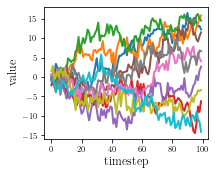

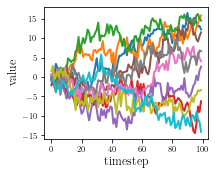

In [49]:
data_preproc = pd.DataFrame({
    'timestep': range(time), 
    'A': [model.measure(t)[0] for model in [SimpleModel(x_0, F, H, Q, R)] for t in range(time)],
    'B': [model.measure(t)[0] for model in [SimpleModel(x_0, F, H, Q, R)] for t in range(time)],
    'C': [model.measure(t)[0] for model in [SimpleModel(x_0, F, H, Q, R)] for t in range(time)],
    'D': [model.measure(t)[0] for model in [SimpleModel(x_0, F, H, Q, R)] for t in range(time)],
    'E': [model.measure(t)[0] for model in [SimpleModel(x_0, F, H, Q, R)] for t in range(time)],
    'F': [model.measure(t)[0] for model in [SimpleModel(x_0, F, H, Q, R)] for t in range(time)],
    'G': [model.measure(t)[0] for model in [SimpleModel(x_0, F, H, Q, R)] for t in range(time)],
    'H': [model.measure(t)[0] for model in [SimpleModel(x_0, F, H, Q, R)] for t in range(time)],
    'I': [model.measure(t)[0] for model in [SimpleModel(x_0, F, H, Q, R)] for t in range(time)],
    'J': [model.measure(t)[0] for model in [SimpleModel(x_0, F, H, Q, R)] for t in range(time)]
    })


g = sns.lineplot(x='timestep', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['timestep']))
g.legend_.remove()
plt.savefig("brownian_motion_runs.pdf", bbox_inches='tight')

In [65]:
pf1 = ParticleFilter(model1, N=1000, resampling_algo='simple_resample', prior_cov_matrix=model1.Q,
                    measurements=measurements, print_results=True)#, ranges=[[-100, 100]])

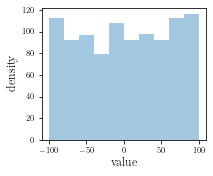

In [36]:
f = plt.figure()

ax = sns.distplot(pf1.particles, kde=False)
ax.set_xlabel("value")
ax.set_ylabel("density")

f.savefig("PF_uniform.pdf", bbox_inches='tight')

Marginal likelihood:  -177.3546


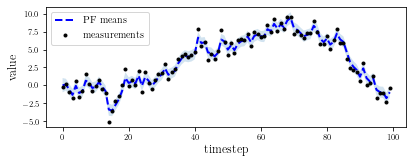

In [66]:
pf_means, pf_variances, pf_likelihood = pf1.run()

Loglikelihood:  -177.47910580848364


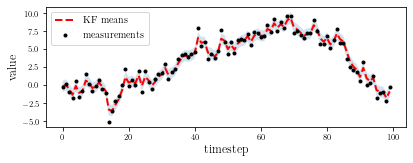

KF ran successfully


In [67]:
kf1 = Kalman(model1, print_results=True, measurements=measurements)
kf_means, kf_variances, kf_loglikelihood = kf1.run()

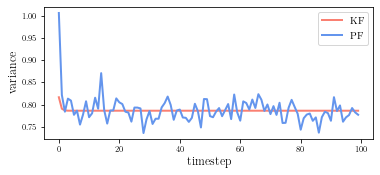

In [68]:
times = range(100)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(times, kf_variances, color='salmon', label='KF')
ax.plot(times, pf_variances, color='cornflowerblue', label='PF')
ax.set_xlabel("timestep")
ax.set_ylabel("variance")
plt.legend()
# plt.show()
plt.savefig("KF_vs_PF_variance_over_time.pdf", bbox_inches='tight')

In [10]:
particles_to_test = [100*x for x in [1,2,3,4,5]]#
particles_to_test = list(range(10, 600, 10))#[10, 20, 30, 70, 100, 200, 300, 400, 500, 600, 800, 1000]#, 1100, 2000, 2200]
time = 100

def test(N):
    pf = ParticleFilter(model1, N=N, resampling_algo='simple_resample', measurements=measurements,
                       prior_cov_matrix=model1.Q)
    _, pf_variances, pf_likelihood1 =  pf.run()
    mean = np.mean(pf_variances[int(.2 * time):])
    var = np.sqrt(np.var(pf_variances[int(.2 * time):]))
    
    pf = ParticleFilter(model1, N=N, resampling_algo='simple_resample', measurements=measurements,
                       prior_cov_matrix=model1.Q)
    _, pf_variances, pf_likelihood2 =  pf.run()
    mean = np.mean(pf_variances[int(.2 * time):])
    var = np.sqrt(np.var(pf_variances[int(.2 * time):]))

    return (pf_variances, mean, var, (pf_likelihood1 + pf_likelihood2)/2)

with Pool(10) as p:
    res = p.map(test, particles_to_test)

res = np.array(res)

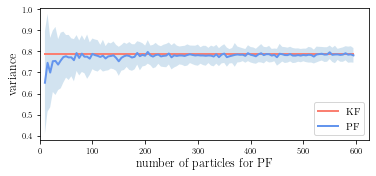

In [8]:
kf1x = Kalman(model1, print_results=False, measurements=measurements)
kf_means, kf_vars, kf_likelihood = kf1x.run()
kf_var = np.mean(kf_vars[int(.2 * time):])

pf_vars = res[:, 1]
pf_vars_vars = res[:, 2]
times = range(len(particles_to_test))
fig = plt.figure()
# fig.suptitle("KF vs PF variances with various number of particles, Gaussian initialization", fontsize=16)
ax = fig.add_subplot(111)

ax.plot(particles_to_test, [kf_var for _ in particles_to_test], color='salmon', label='KF')
ax.plot(particles_to_test, pf_vars, color='cornflowerblue', label='PF')

pfvar_neg = list(pf_vars - pf_vars_vars)
pfvar_pos = list(pf_vars + pf_vars_vars)
ax.fill_between(particles_to_test, pfvar_pos, pfvar_neg, alpha=0.2)
ax.set_xlim(left=0)
ax.set_xlabel("number of particles for PF")
ax.set_ylabel("variance")
ax.legend(loc='lower right')
plt.savefig("PF_vs_KF_var_of_var_over_N.pdf", bbox_inches='tight')
plt.show()

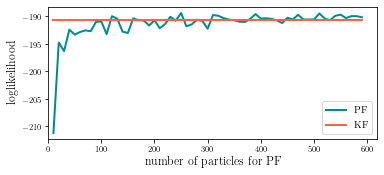

In [11]:
times = range(len(particles_to_test))
pf_likelihoods = res[:, 3]
fig = plt.figure()
# fig.suptitle("PF likelihood, Gaussian initialization", fontsize=16)
ax = fig.add_subplot(111)
ax.plot(particles_to_test, pf_likelihoods, color='darkcyan', label='PF')
ax.plot(particles_to_test, [kf_likelihood] * len(particles_to_test), color='tomato', label='KF')
ax.set_xlabel("number of particles for PF")
ax.set_ylabel("loglikelihood")
ax.set_xlim(left=0)
plt.legend(loc='lower right')
plt.savefig("PF_vs_KF_likelihood_over_N.pdf", bbox_inches='tight')
plt.show()

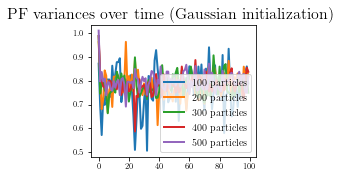

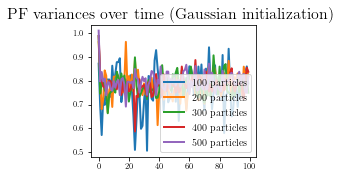

In [62]:
variances = res[:, 0]
times = range(time)
fig = plt.figure()
fig.suptitle("PF variances over time (Gaussian initialization)", fontsize=16)
ax = fig.add_subplot(111)
for nr in range(len(particles_to_test)):
    ax.plot(times, variances[nr], label=str(particles_to_test[nr])+" particles")
ax.legend()
plt.show()

In [6]:
particles_to_test = [10, 15, 20, 25, 30, 35, 45, 50, 70, 100, 200, 300, 400, 500]#, 600, 800, 1000]#, 1100, 2000, 2200]
time = 50

from multiprocessing import Pool
def test(N):
    pf = ParticleFilter(model1, N=N, resampling_algo='simple_resample', ranges=[[-100, 100]], 
                        print_results=False, measurements=measurements)
    _, pf_variances, pf_likelihood =  pf.run()
    mean = np.mean(pf_variances[int(.2 * time):])
    var = np.var(pf_variances[int(.2 * time):])

    return (pf_variances, mean, var, pf_likelihood)

with Pool(10) as p:
    res = p.map(test, particles_to_test)

res = np.array(res)

In [ ]:
kf1x = Kalman(model1, print_results=False, measurement_err_cov_matrix=model1.R)
kf_means, kf_vars, kf_likelihood = kf1x.run(time)
kf_var = np.mean(kf_variances[int(.2 * time):])

pf_vars = res[:, 1]
pf_vars_vars = res[:, 2]
times = range(len(particles_to_test))
fig = plt.figure()
fig.suptitle("KF vs PF variances with various number of particles, Uniform initialization", fontsize=16)
ax = fig.add_subplot(111)

ax.plot(particles_to_test, [kf_var for _ in particles_to_test], 'g', label='KF variance')
ax.plot(particles_to_test, pf_vars, 'b', label='PF variances')

pfvar_neg = list(pf_vars - pf_vars_vars)
pfvar_pos = list(pf_vars + pf_vars_vars)
ax.fill_between(particles_to_test, pfvar_pos, pfvar_neg, alpha=0.2)
ax.set_xlim(left=0)
ax.set_xlabel("Number of particles")
ax.legend()
plt.show()

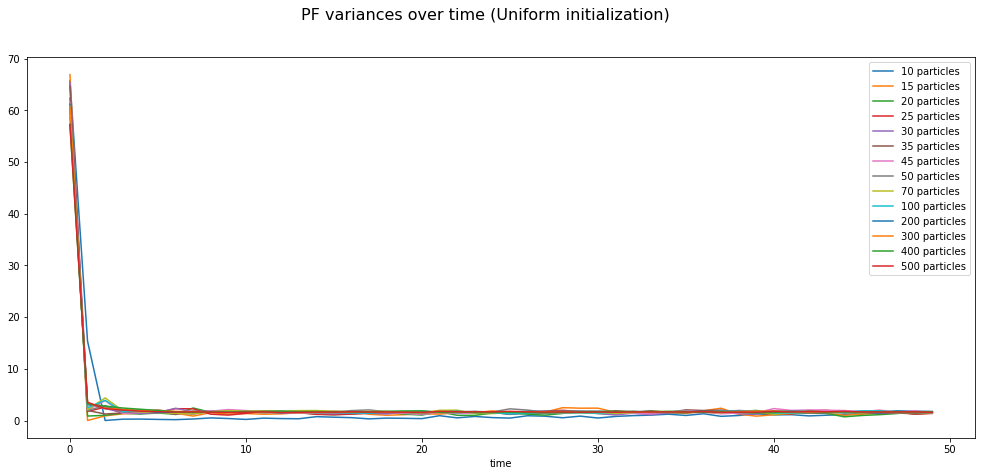

In [25]:
variances = res[:, 0]
times = range(time)
fig = plt.figure()
fig.suptitle("PF variances over time (Uniform initialization)", fontsize=16)
ax = fig.add_subplot(111)
for nr in range(len(particles_to_test)):
    ax.plot(times, variances[nr], label=str(particles_to_test[nr])+" particles")
ax.legend()
ax.set_xlabel("time")
plt.show()

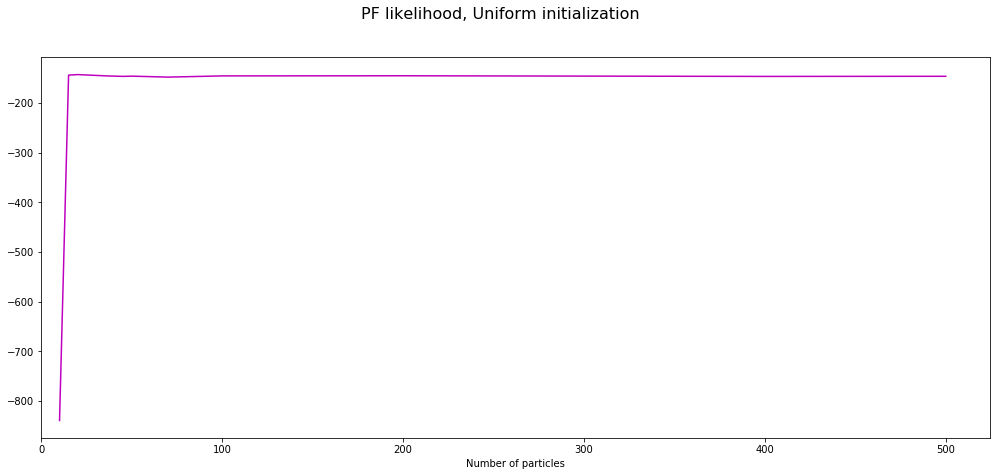

In [26]:
times = range(len(particles_to_test))
pf_likelihoods = res[:, 3]
fig = plt.figure()
fig.suptitle("PF likelihood, Uniform initialization", fontsize=16)
ax = fig.add_subplot(111)
ax.plot(particles_to_test, pf_likelihoods, 'm')
ax.set_xlabel("Number of particles")
ax.set_xlim(left=0)
plt.show()

# This section does some very basic parameter inference for the 1D model

In [18]:
def avg(xs):
    noninf = xs[xs != -np.inf]
    return np.average(noninf) if len(noninf) else -np.inf

In [27]:
def PF_likelihood(testcase):
    model, measurements, N = testcase
    return ParticleFilter(model, N=N, measurements=measurements, prior_cov_matrix=model.Q).run()[2]

In [28]:
def KF_likelihood(testcase):
    model, measurements = testcase
    return Kalman(model, measurements).run()[2]

In [29]:
def test_likelihoods_pf_kf_simple_f():
    x_0 = np.array([0.])
    F = np.array([[1.]])
    H = np.array([[1.]])
    Q = np.array([[1.]])
    R = np.array([[1.]])
    
    iterations = 5
    time = 50
    N = 100
    
    real_model = SimpleModel(x_0, F, H, Q, R)
    measurements = [real_model.measure(t) for t in range(time)]    
    
    F_values_to_test = [np.array([[i]]) for i in np.linspace(-2, 2, 50)]
    models_to_test = [SimpleModel(x_0, F_, H, Q, R) for F_ in F_values_to_test]
    
    PF_tests = [(model, measurements, N) for model in models_to_test]
    KF_tests = [(model, measurements) for model in models_to_test]
    
    pf_likelihoods_tests = []
    kf_likelihoods_tests = []
    for _ in range(iterations):
        pf_likelihoods_tests.append(np.array(list(map(PF_likelihood, PF_tests))))
        kf_likelihoods_tests.append(np.array(list(map(KF_likelihood, KF_tests))))
    
    pf_likelihoods = np.array(list(map(avg, np.array(pf_likelihoods_tests).T)))
    kf_likelihoods = np.array(list(map(avg, np.array(kf_likelihoods_tests).T)))
    
    xs = list(map(lambda x: x[0][0], F_values_to_test))
    
    f = plt.figure()
    plt.plot(xs, pf_likelihoods, color='darkcyan', label='PF')
    plt.plot(xs, kf_likelihoods, color='tomato', label='KF')

    plt.axvline(x=Q[0][0], color='k', label='real value')
    plt.ylabel("loglikelihood")
    plt.xlabel("F values")
#     plt.xscale("log")
    plt.legend()
    f.savefig(f"test_f_{tttt.time()}.pdf", bbox_inches='tight')
    plt.show()
    return pf_likelihoods, kf_likelihoods

In [30]:
def test_likelihoods_pf_kf_simple_h():
    x_0 = np.array([0.])
    F = np.array([[1.]])
    H = np.array([[1.]])
    Q = np.array([[1.]])
    R = np.array([[1.]])
    
    iterations = 5
    time = 50
    N = 100
    
    real_model = SimpleModel(x_0, F, H, Q, R)
    measurements = [real_model.measure(t) for t in range(time)]    
    
    H_values_to_test = [np.array([[10. ** i]]) for i in range(-5, 5)]

    models_to_test = [SimpleModel(x_0, F, H_, Q, R) for H_ in H_values_to_test]
    
    PF_tests = [(model, measurements, N) for model in models_to_test]
    KF_tests = [(model, measurements) for model in models_to_test]
    
    pf_likelihoods_tests = []
    kf_likelihoods_tests = []
    for _ in range(iterations):
        pf_likelihoods_tests.append(np.array(list(map(PF_likelihood, PF_tests))))
        kf_likelihoods_tests.append(np.array(list(map(KF_likelihood, KF_tests))))

    
    pf_likelihoods = np.array(list(map(avg, np.array(pf_likelihoods_tests).T)))
    kf_likelihoods = np.array(list(map(avg, np.array(kf_likelihoods_tests).T)))
    
    xs = list(map(lambda x: x[0][0], H_values_to_test))
    plt.plot(xs, pf_likelihoods, color='darkcyan', label='PF')
    plt.plot(xs, kf_likelihoods, color='tomato', label='KF')

    plt.axvline(x=Q[0][0], color='k', label='real value')
    plt.ylabel("loglikelihood")
    plt.xlabel("H values")
    plt.xscale("log")
    plt.legend()
    plt.savefig(f"test_h_{tttt.time()}.pdf", bbox_inches='tight')


    plt.show()
    return pf_likelihoods, kf_likelihoods

In [31]:
def test_likelihoods_pf_kf_simple_q():
    x_0 = np.array([0.])
    F = np.array([[1.]])
    H = np.array([[1.]])
    Q = np.array([[1.]])
    R = np.array([[1.]])
    
    iterations = 5
    time = 50
    N = 100
    
    real_model = SimpleModel(x_0, F, H, Q, R)
    measurements = [real_model.measure(t) for t in range(time)]    
    
    Q_values_to_test = [np.array([[10. ** i]]) for i in range(-5, 5)]
    models_to_test = [SimpleModel(x_0, F, H, Q_, R) for Q_ in Q_values_to_test]
    
    PF_tests = [(model, measurements, N) for model in models_to_test]
    KF_tests = [(model, measurements) for model in models_to_test]
    
    pf_likelihoods_tests = []
    kf_likelihoods_tests = []
    for _ in range(iterations):
        pf_likelihoods_tests.append(np.array(list(map(PF_likelihood, PF_tests))))
        kf_likelihoods_tests.append(np.array(list(map(KF_likelihood, KF_tests))))

    
    pf_likelihoods = np.array(list(map(avg, np.array(pf_likelihoods_tests).T)))
    kf_likelihoods = np.array(list(map(avg, np.array(kf_likelihoods_tests).T)))
    
    xs = list(map(lambda x: x[0][0], Q_values_to_test))
    plt.plot(xs, pf_likelihoods, color='darkcyan', label='PF')
    plt.plot(xs, kf_likelihoods, color='tomato', label='KF')

    plt.axvline(x=Q[0][0], color='k', label='real value')
    plt.ylabel("loglikelihood")
    plt.xlabel("Q values")
    plt.xscale("log")
    plt.legend()
    plt.savefig(f"test_q_{tttt.time()}.pdf", bbox_inches='tight')


    plt.show()
    return pf_likelihoods, kf_likelihoods

In [81]:
def test_likelihoods_pf_kf_simple_r():
    x_0 = np.array([0.])
    F = np.array([[1.]])
    H = np.array([[1.]])
    Q = np.array([[1.]])
    R = np.array([[1.]])
    
    iterations = 5
    time = 50
    N = 100
    
    real_model = SimpleModel(x_0, F, H, Q, R)
    measurements = [real_model.measure(t) for t in range(time)]    
    
    R_values_to_test = [np.array([[10. ** i]]) for i in range(-3, 5)]

    models_to_test = [SimpleModel(x_0, F, H, Q, R_) for R_ in R_values_to_test]
    
    PF_tests = [(model, measurements, N) for model in models_to_test]
    KF_tests = [(model, measurements) for model in models_to_test]
    
    pf_likelihoods_tests = []
    kf_likelihoods_tests = []
    for _ in range(iterations):
        pf_likelihoods_tests.append(np.array(list(map(PF_likelihood, PF_tests))))
        kf_likelihoods_tests.append(np.array(list(map(KF_likelihood, KF_tests))))

    
    pf_likelihoods = np.array(list(map(avg, np.array(pf_likelihoods_tests).T)))
    kf_likelihoods = np.array(list(map(avg, np.array(kf_likelihoods_tests).T)))
    
    xs = list(map(lambda x: x[0][0], R_values_to_test))
    plt.plot(xs, list(map(lambda x: x-20, pf_likelihoods)), color='darkcyan', label='PF')
    plt.plot(xs, kf_likelihoods, color='tomato', label='KF')

    plt.axvline(x=Q[0][0], color='k', label='real value')
    plt.ylabel("loglikelihood")
    plt.xlabel("R values")
    plt.xscale("log")
    plt.legend()
    plt.savefig(f"test_r_{tttt.time()}.pdf", bbox_inches='tight')


    plt.show()
    return pf_likelihoods, kf_likelihoods

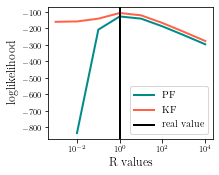

In [82]:
_ = test_likelihoods_pf_kf_simple_r()

# Testing different resampling strategies

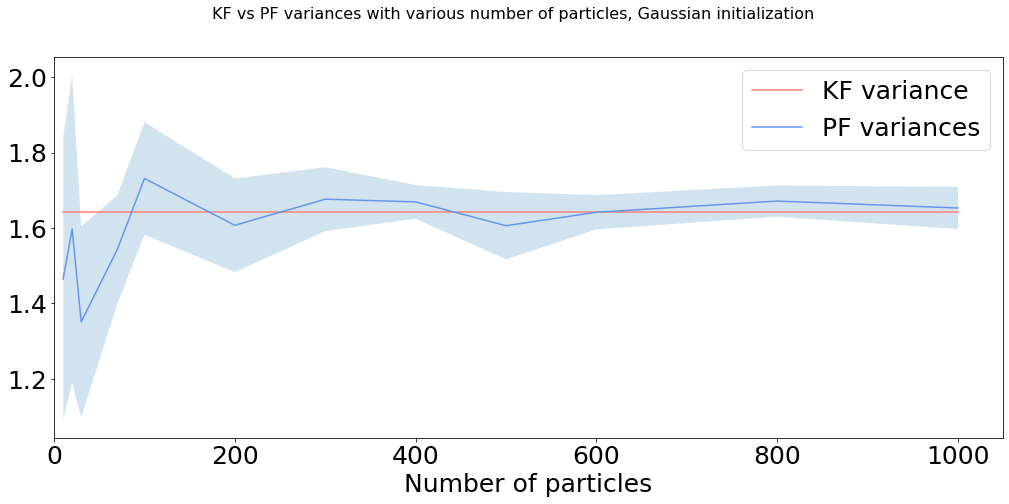

Final var of var (width):  0.05586659209348289


In [12]:
# simple_resample, 1/3
particles_to_test = [10, 20, 30, 70, 100, 200, 300, 400, 500, 600, 800, 1000]#, 1100, 2000, 2200]
x_0 = np.array([0.])
F = np.array([[1.]])
H = np.array([[1.]])
Q = np.array([[1.]])
R = np.array([[1.]]) * 10


model1 = SimpleModel(x_0, F, H, Q, R)
time = 50
measurements = [model1.measure(t) for t in range(time)]

def test(N):
    pf = ParticleFilter(model1, N=N, resampling_algo="simple_resample", 
                       prior_cov_matrix=model1.Q, measurements=measurements, neff_threshold=1/3)
    _, pf_variances, pf_likelihood =  pf.run()
    mean = np.mean(pf_variances[int(.2 * time):])
    var = np.sqrt(np.var(pf_variances[int(.2 * time):]))

    return (pf_variances, mean, var, pf_likelihood)

with Pool(10) as p:
    res = p.map(test, particles_to_test)

res = np.array(res)


kf1x = Kalman(model1, print_results=False, measurements=measurements)
kf_means, kf_vars, kf_likelihood = kf1x.run()
kf_var = np.mean(kf_vars[int(.2 * time):])

pf_vars = res[:, 1]
pf_vars_vars = res[:, 2]
times = range(len(particles_to_test))
fig = plt.figure()
fig.suptitle("KF vs PF variances with various number of particles, Gaussian initialization", fontsize=16)
ax = fig.add_subplot(111)

ax.plot(particles_to_test, [kf_var for _ in particles_to_test], color='salmon', label='KF variance')
ax.plot(particles_to_test, pf_vars, color='cornflowerblue', label='PF variances')

pfvar_neg = list(pf_vars - pf_vars_vars)
pfvar_pos = list(pf_vars + pf_vars_vars)
ax.fill_between(particles_to_test, pfvar_pos, pfvar_neg, alpha=0.2)
ax.set_xlim(left=0)
ax.set_xlabel("Number of particles")
ax.legend()
plt.show()

print("Final var of var (width): ", pf_vars_vars[-1])

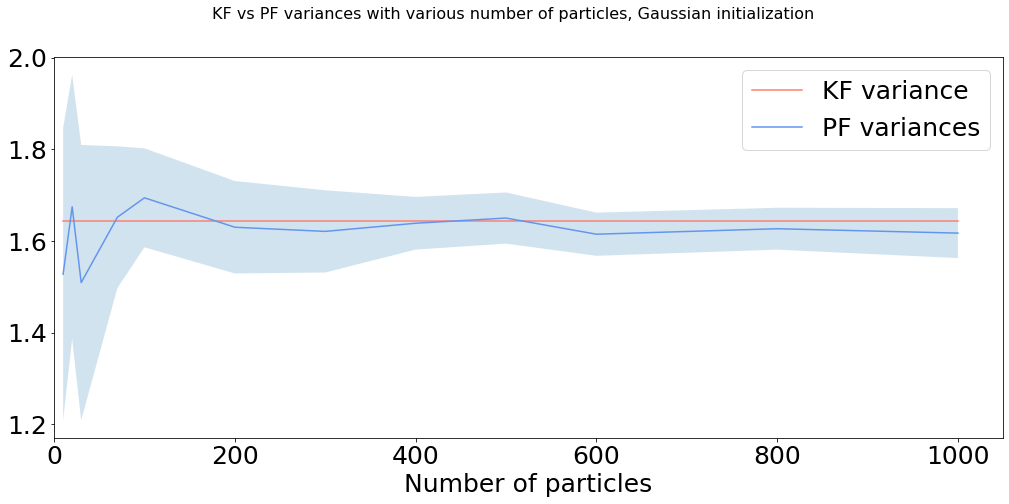

Final var of var (width):  0.05453341776252718


In [13]:
# stratified_resample, 1/3
particles_to_test = [10, 20, 30, 70, 100, 200, 300, 400, 500, 600, 800, 1000]#, 1100, 2000, 2200]
x_0 = np.array([0.])
F = np.array([[1.]])
H = np.array([[1.]])
Q = np.array([[1.]])
R = np.array([[1.]]) * 10


model1 = SimpleModel(x_0, F, H, Q, R)
time = 50
measurements = [model1.measure(t) for t in range(time)]

def test(N):
    pf = ParticleFilter(model1, N=N, resampling_algo="stratified_resample",
                       prior_cov_matrix=model1.Q, measurements=measurements, neff_threshold=1/3)
    _, pf_variances, pf_likelihood =  pf.run()
    mean = np.mean(pf_variances[int(.2 * time):])
    var = np.sqrt(np.var(pf_variances[int(.2 * time):]))

    return (pf_variances, mean, var, pf_likelihood)

with Pool(10) as p:
    res = p.map(test, particles_to_test)

res = np.array(res)


kf1x = Kalman(model1, print_results=False, measurements=measurements)
kf_means, kf_vars, kf_likelihood = kf1x.run()
kf_var = np.mean(kf_vars[int(.2 * time):])

pf_vars = res[:, 1]
pf_vars_vars = res[:, 2]
times = range(len(particles_to_test))
fig = plt.figure()
fig.suptitle("KF vs PF variances with various number of particles, Gaussian initialization", fontsize=16)
ax = fig.add_subplot(111)
ax.plot(particles_to_test, [kf_var for _ in particles_to_test], color='salmon', label='KF variance')
ax.plot(particles_to_test, pf_vars, color='cornflowerblue', label='PF variances')



pfvar_neg = list(pf_vars - pf_vars_vars)
pfvar_pos = list(pf_vars + pf_vars_vars)
ax.fill_between(particles_to_test, pfvar_pos, pfvar_neg, alpha=0.2)
ax.set_xlim(left=0)
ax.set_xlabel("Number of particles")
ax.legend()
plt.show()

print("Final var of var (width): ", pf_vars_vars[-1])

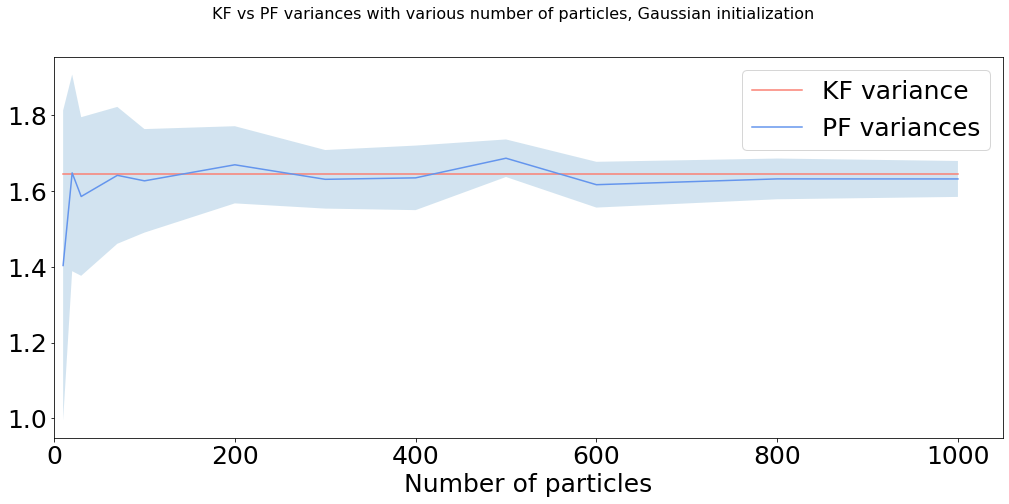

Final var of var (width):  0.04742161843907234


In [14]:
# residual_resample, 1/3
particles_to_test = [10, 20, 30, 70, 100, 200, 300, 400, 500, 600, 800, 1000]#, 1100, 2000, 2200]
x_0 = np.array([0.])
F = np.array([[1.]])
H = np.array([[1.]])
Q = np.array([[1.]])
R = np.array([[1.]]) * 10


model1 = SimpleModel(x_0, F, H, Q, R)
time = 50
measurements = [model1.measure(t) for t in range(time)]

def test(N):
    pf = ParticleFilter(model1, N=N, resampling_algo="residual_resample",
                       prior_cov_matrix=model1.Q, measurements=measurements, neff_threshold=1/3)
    _, pf_variances, pf_likelihood =  pf.run()
    mean = np.mean(pf_variances[int(.2 * time):])
    var = np.sqrt(np.var(pf_variances[int(.2 * time):]))

    return (pf_variances, mean, var, pf_likelihood)

with Pool(10) as p:
    res = p.map(test, particles_to_test)

res = np.array(res)


kf1x = Kalman(model1, print_results=False, measurements=measurements)
kf_means, kf_vars, kf_likelihood = kf1x.run()
kf_var = np.mean(kf_vars[int(.2 * time):])

pf_vars = res[:, 1]
pf_vars_vars = res[:, 2]
times = range(len(particles_to_test))
fig = plt.figure()
fig.suptitle("KF vs PF variances with various number of particles, Gaussian initialization", fontsize=16)
ax = fig.add_subplot(111)
ax.plot(particles_to_test, [kf_var for _ in particles_to_test], color='salmon', label='KF variance')
ax.plot(particles_to_test, pf_vars, color='cornflowerblue', label='PF variances')


pfvar_neg = list(pf_vars - pf_vars_vars)
pfvar_pos = list(pf_vars + pf_vars_vars)
ax.fill_between(particles_to_test, pfvar_pos, pfvar_neg, alpha=0.2)
ax.set_xlim(left=0)
ax.set_xlabel("Number of particles")
ax.legend()
plt.show()

print("Final var of var (width): ", pf_vars_vars[-1])

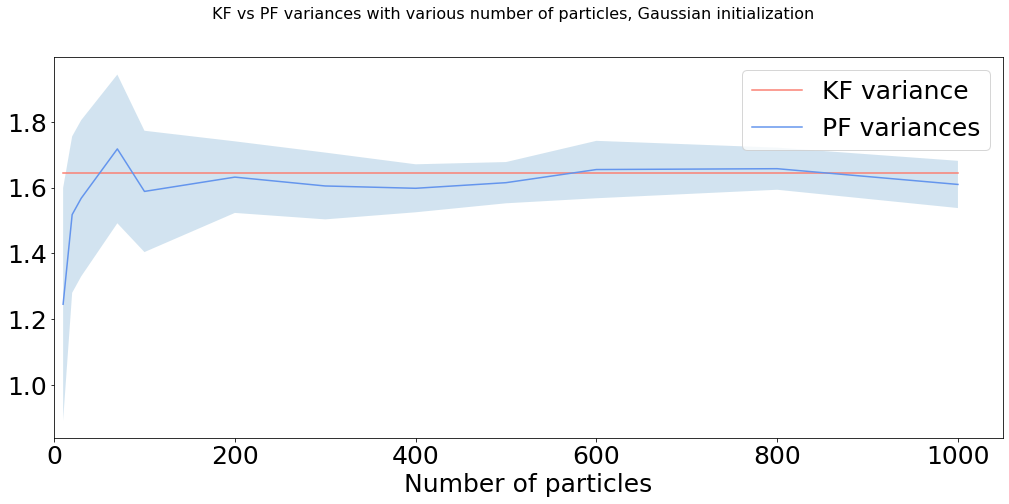

Final var of var (width):  0.07181727620279595


In [15]:
# residual_resample, 1/4
particles_to_test = [10, 20, 30, 70, 100, 200, 300, 400, 500, 600, 800, 1000]#, 1100, 2000, 2200]
x_0 = np.array([0.])
F = np.array([[1.]])
H = np.array([[1.]])
Q = np.array([[1.]])
R = np.array([[1.]]) * 10


model1 = SimpleModel(x_0, F, H, Q, R)
time = 50
measurements = [model1.measure(t) for t in range(time)]

def test(N):
    pf = ParticleFilter(model1, N=N, resampling_algo="residual_resample", 
                       prior_cov_matrix=model1.Q, measurements=measurements, neff_threshold=1/4)
    _, pf_variances, pf_likelihood =  pf.run()
    mean = np.mean(pf_variances[int(.2 * time):])
    var = np.sqrt(np.var(pf_variances[int(.2 * time):]))

    return (pf_variances, mean, var, pf_likelihood)

with Pool(10) as p:
    res = p.map(test, particles_to_test)

res = np.array(res)


kf1x = Kalman(model1, print_results=False, measurements=measurements)
kf_means, kf_vars, kf_likelihood = kf1x.run()
kf_var = np.mean(kf_vars[int(.2 * time):])

pf_vars = res[:, 1]
pf_vars_vars = res[:, 2]
times = range(len(particles_to_test))
fig = plt.figure()
fig.suptitle("KF vs PF variances with various number of particles, Gaussian initialization", fontsize=16)
ax = fig.add_subplot(111)

ax.plot(particles_to_test, [kf_var for _ in particles_to_test], color='salmon', label='KF variance')
ax.plot(particles_to_test, pf_vars, color='cornflowerblue', label='PF variances')


pfvar_neg = list(pf_vars - pf_vars_vars)
pfvar_pos = list(pf_vars + pf_vars_vars)
ax.fill_between(particles_to_test, pfvar_pos, pfvar_neg, alpha=0.2)
ax.set_xlim(left=0)
ax.set_xlabel("Number of particles")
ax.legend()
plt.show()

print("Final var of var (width): ", pf_vars_vars[-1])

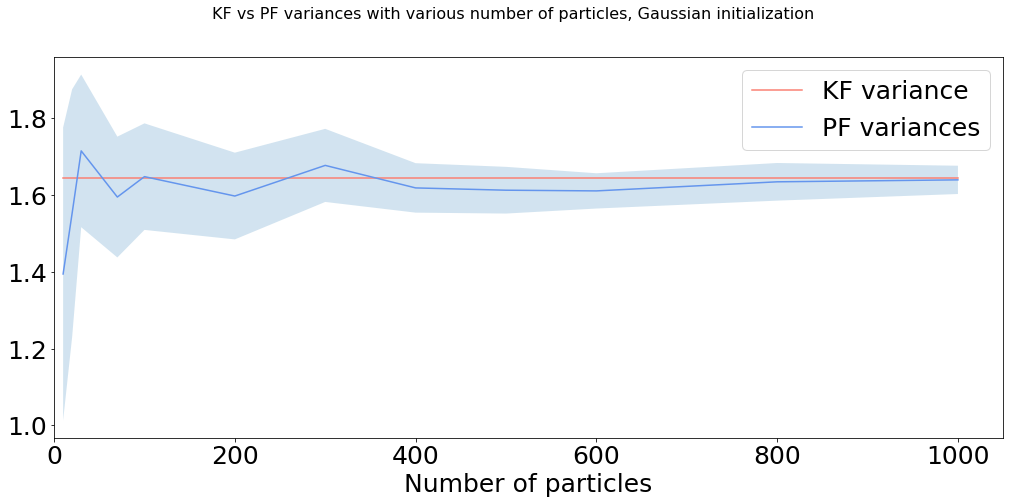

Final var of var (width):  0.036864155794643305


In [16]:
# residual_resample, 1/2
particles_to_test = [10, 20, 30, 70, 100, 200, 300, 400, 500, 600, 800, 1000]#, 1100, 2000, 2200]
x_0 = np.array([0.])
F = np.array([[1.]])
H = np.array([[1.]])
Q = np.array([[1.]])
R = np.array([[1.]]) * 10


model1 = SimpleModel(x_0, F, H, Q, R)
time = 50
measurements = [model1.measure(t) for t in range(time)]

def test(N):
    pf = ParticleFilter(model1, N=N, resampling_algo="residual_resample", 
                       prior_cov_matrix=model1.Q, measurements=measurements, neff_threshold=1/2)
    _, pf_variances, pf_likelihood =  pf.run()
    mean = np.mean(pf_variances[int(.2 * time):])
    var = np.sqrt(np.var(pf_variances[int(.2 * time):]))

    return (pf_variances, mean, var, pf_likelihood)

with Pool(10) as p:
    res = p.map(test, particles_to_test)

res = np.array(res)


kf1x = Kalman(model1, print_results=False,  measurements=measurements)
kf_means, kf_vars, kf_likelihood = kf1x.run()
kf_var = np.mean(kf_vars[int(.2 * time):])

pf_vars = res[:, 1]
pf_vars_vars = res[:, 2]
times = range(len(particles_to_test))
fig = plt.figure()
fig.suptitle("KF vs PF variances with various number of particles, Gaussian initialization", fontsize=16)
ax = fig.add_subplot(111)

ax.plot(particles_to_test, [kf_var for _ in particles_to_test], color='salmon', label='KF variance')
ax.plot(particles_to_test, pf_vars, color='cornflowerblue', label='PF variances')


pfvar_neg = list(pf_vars - pf_vars_vars)
pfvar_pos = list(pf_vars + pf_vars_vars)
ax.fill_between(particles_to_test, pfvar_pos, pfvar_neg, alpha=0.2)
ax.set_xlim(left=0)
ax.set_xlabel("Number of particles")
ax.legend()
plt.show()

print("Final var of var (width): ", pf_vars_vars[-1])

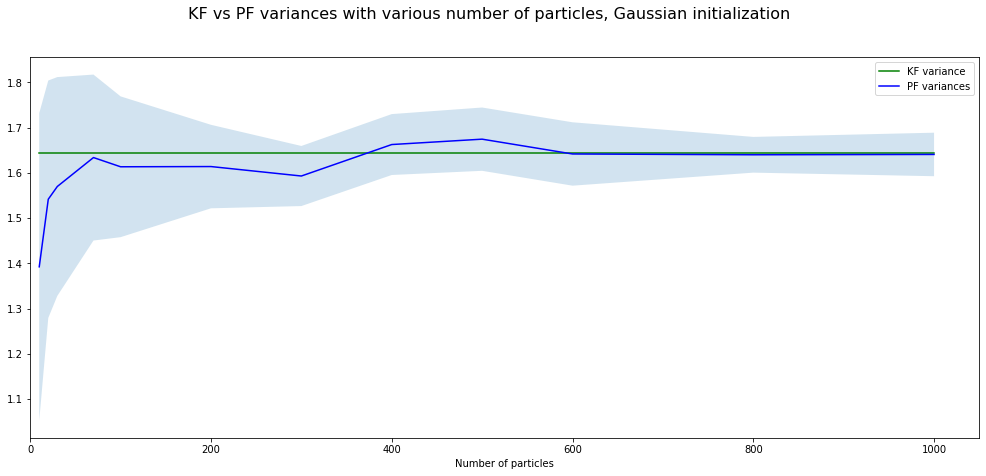

Final var of var (width):  0.048089367831532316


In [92]:
# residual_resample, 3/4
particles_to_test = [10, 20, 30, 70, 100, 200, 300, 400, 500, 600, 800, 1000]#, 1100, 2000, 2200]
x_0 = np.array([0.])
F = np.array([[1.]])
H = np.array([[1.]])
Q = np.array([[1.]])
R = np.array([[1.]]) * 10


model1 = SimpleModel(x_0, F, H, Q, R)
time = 50
measurements = [model1.measure(t) for t in range(time)]

def test(N):
    pf = ParticleFilter(model1, N=N, resampling_algo="residual_resample", x_0=model1.states[0], 
                        print_results=False, measurement_err_cov_matrix=model1.R,
                       prior_cov_matrix=model1.Q, measurements=measurements, neff_threshold=3/4)
    _, pf_variances, pf_likelihood =  pf.run(time)
    mean = np.mean(pf_variances[int(.2 * time):])
    var = np.sqrt(np.var(pf_variances[int(.2 * time):]))

    return (pf_variances, mean, var, pf_likelihood)

with Pool(10) as p:
    res = p.map(test, particles_to_test)

res = np.array(res)


kf1x = Kalman(model1, print_results=False, measurement_err_cov_matrix=model1.R, measurements=measurements)
kf_means, kf_vars, kf_likelihood = kf1x.run(time)
kf_var = np.mean(kf_vars[int(.2 * time):])

pf_vars = res[:, 1]
pf_vars_vars = res[:, 2]
times = range(len(particles_to_test))
fig = plt.figure()
fig.suptitle("KF vs PF variances with various number of particles, Gaussian initialization", fontsize=16)
ax = fig.add_subplot(111)

ax.plot(particles_to_test, [kf_var for _ in particles_to_test], 'g', label='KF variance')
ax.plot(particles_to_test, pf_vars, 'b', label='PF variances')

pfvar_neg = list(pf_vars - pf_vars_vars)
pfvar_pos = list(pf_vars + pf_vars_vars)
ax.fill_between(particles_to_test, pfvar_pos, pfvar_neg, alpha=0.2)
ax.set_xlim(left=0)
ax.set_xlabel("Number of particles")
ax.legend()
plt.show()

print("Final var of var (width): ", pf_vars_vars[-1])

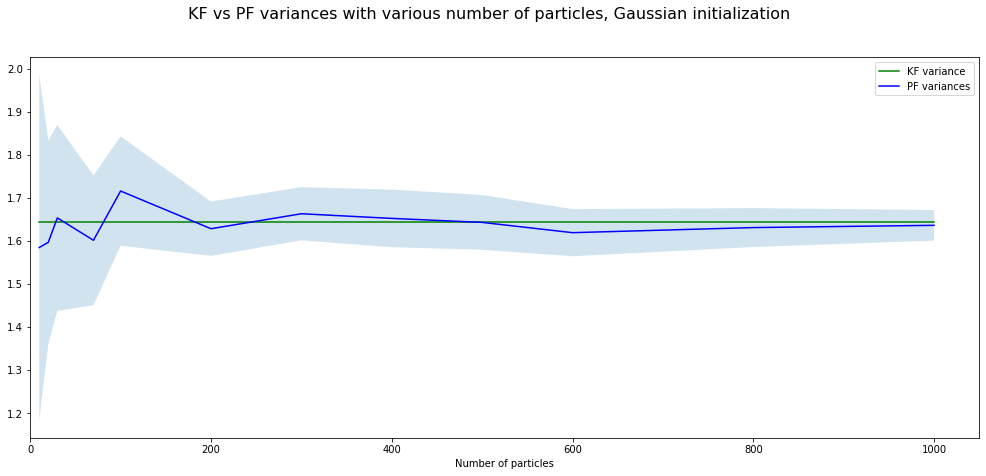

Final var of var (width):  0.03553397320589715


In [28]:
# systematic_resample, 1/2
particles_to_test = [10, 20, 30, 70, 100, 200, 300, 400, 500, 600, 800, 1000]#, 1100, 2000, 2200]
x_0 = np.array([0.])
F = np.array([[1.]])
H = np.array([[1.]])
Q = np.array([[1.]])
R = np.array([[1.]]) * 10


model1 = SimpleModel(x_0, F, H, Q, R)
time = 50
measurements = [model1.measure(t) for t in range(time)]

def test(N):
    pf = ParticleFilter(model1, N=N, resampling_algo="systematic_resample", x_0=model1.states[0], 
                        print_results=False, measurement_err_cov_matrix=model1.R,
                       prior_cov_matrix=model1.Q, measurements=measurements, neff_threshold=1/2)
    _, pf_variances, pf_likelihood =  pf.run(time)
    mean = np.mean(pf_variances[int(.2 * time):])
    var = np.sqrt(np.var(pf_variances[int(.2 * time):]))

    return (pf_variances, mean, var, pf_likelihood)

with Pool(10) as p:
    res = p.map(test, particles_to_test)

res = np.array(res)


kf1x = Kalman(model1, print_results=False, measurement_err_cov_matrix=model1.R, measurements=measurements)
kf_means, kf_vars, kf_likelihood = kf1x.run(time)
kf_var = np.mean(kf_vars[int(.2 * time):])

pf_vars = res[:, 1]
pf_vars_vars = res[:, 2]
times = range(len(particles_to_test))
fig = plt.figure()
fig.suptitle("KF vs PF variances with various number of particles, Gaussian initialization", fontsize=16)
ax = fig.add_subplot(111)

ax.plot(particles_to_test, [kf_var for _ in particles_to_test], 'g', label='KF variance')
ax.plot(particles_to_test, pf_vars, 'b', label='PF variances')

pfvar_neg = list(pf_vars - pf_vars_vars)
pfvar_pos = list(pf_vars + pf_vars_vars)
ax.fill_between(particles_to_test, pfvar_pos, pfvar_neg, alpha=0.2)
ax.set_xlim(left=0)
ax.set_xlabel("Number of particles")
ax.legend()
plt.show()

print("Final var of var (width): ", pf_vars_vars[-1])

In [11]:
x_0 = np.array([0.])
F = np.array([[1.]])
H = np.array([[1.]])
Q = np.array([[1.]])
R = np.array([[1.]]) * 10


model1 = SimpleModel(x_0, F, H, Q, R)
time = 200
measurements = [model1.measure(t) for t in range(time)]

algos = ['simple_resample', 'residual_resample', 'stratified_resample', 'systematic_resample']
thresholds = np.round(np.linspace(.2, .95, 5), 2)
tests = [(threshold, algo) for threshold in thresholds for algo in algos]

def test(tup):
    thr, algo = tup
    pf = ParticleFilter(model1, N=1000, resampling_algo=algo, 
                       prior_cov_matrix=model1.Q, measurements=measurements, neff_threshold=thr)
    _, pf_variances, pf_likelihood =  pf.run()
    mean = np.mean(pf_variances[int(.2 * time):])
    var = np.sqrt(np.var(pf_variances[int(.2 * time):]))

    return var

with Pool(10) as p:
    res = p.map(test, tests)

res = np.array(res)

In [12]:
df = pd.DataFrame(tests, columns=['neff threshold', 'algorithm'])
df['result'] = res
df = df.pivot("neff threshold", "algorithm", "result")

In [ ]:
pl = sns.heatmap(df, annot=True)

In [ ]:
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show() # ta-da!

# Simple 2D example

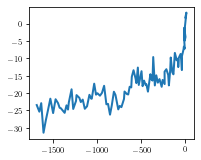

In [85]:
x_0 = np.array([0., 0.])
F = np.array([[1., 1.], [0., 1.]])
H = np.array([[1., 0.], [0., 1.]])
Q = np.array([[1., 0.], [0., 1.]])
R = np.array([[20., 0.], [0., 5.]])

time = 100
model2 = SimpleModel(x_0, F, H, Q, R)
measurements = [model2.measure(t) for t in range(time)]

# plt.rcParams['lines.linewidth'] = 1#2.0

real_xs, real_ys = np.array(measurements)[:, 0], np.array(measurements)[:, 1]
plt.plot(real_xs, real_ys)

In [86]:
pf2 = ParticleFilter(model2, N=1000, resampling_algo='systematic_resample', 
                    measurements=measurements, prior_cov_matrix=model2.Q, print_results=True)#, ranges=[(-100, 100), (-50, 50)])

Marginal likelihood:  -563.6539


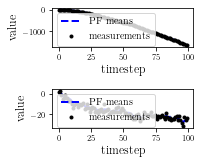

In [87]:
pf_means, pf_vars, pf_likelihood = pf2.run()

Loglikelihood:  -563.5505852719012


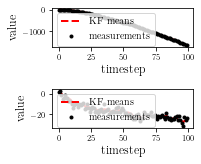

KF ran successfully


In [88]:
kf2 = Kalman(model2, print_results=True, measurements=measurements)
kf_means, kf_variances, kf_likelihood = kf2.run()

In [89]:
xs, ys = pf_means[:, 0], pf_means[:, 1]
kf_xs, kf_ys = kf_means[:, 0], kf_means[:, 1]
real_xs, real_ys = np.array(measurements)[:, 0], np.array(measurements)[:, 1]

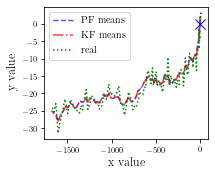

In [90]:
# plt.rcParams['lines.linewidth'] = 1.5
fig, ax = plt.subplots()
ax.plot(xs, ys, 'b--', label='PF means', alpha=0.7, linewidth=1.4)
ax.plot(kf_xs, kf_ys, 'r-.', label='KF means', alpha=0.7, linewidth=1.6)
ax.set_xlabel('x value')
ax.set_ylabel('y value')
ax.plot(real_xs, real_ys, 'g:', label='real', linewidth=1.5)
ax.legend()

ax.plot(xs[0], ys[0], 'bx', markersize=10)

plt.savefig("pf_running_on_2d.pdf", bbox_inches='tight')

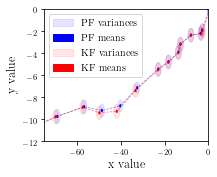

In [96]:
from matplotlib.patches import Ellipse
fig, ax = plt.subplots()
ax.plot(xs, ys, 'b--', alpha=0.5, linewidth=0.7)
ax.plot(kf_xs, kf_ys, 'r--', alpha=0.5, linewidth=0.7)


# pfm = ax.plot(xs, ys, 'ro', markersize=2, alpha=1, linewidth=1.4, label='PF means')

ax.set_xlabel('x value')
ax.set_ylabel('y value')



xvars, yvars = pf_vars[:, 0], pf_vars[:, 1]
el1, el2 = None, None

k = .5
for x, y, xvar, yvar in zip(xs, ys, xvars, yvars):
    e = Ellipse((x,y), width=xvar, height=yvar, color='b', fill=True, alpha=0.1)
    p = Ellipse((x,y), width=k, height=k * 31/75, color='b', fill=True, alpha=1)
    ax.add_artist(e)
    ax.add_artist(p)
    el1 = e
    el2 = p
    
kf_xvar, kf_yvar = kf_variances[:, 0], kf_variances[:, 1]
el3, el4 = None, None
for x, y, xvar, yvar in zip(kf_xs, kf_ys, kf_xvar, kf_yvar):
    e = Ellipse((x,y), width=xvar, height=yvar, color='r', fill=True, alpha=0.1)
    p = Ellipse((x,y), width=k, height=k * 31/75, color='r', fill=True, alpha=1)
    ax.add_artist(e)
    ax.add_artist(p)
    el3 = e
    el4 = p
    
# ax.legend(e, ['asd'])
ax.set_ylim(-12, 0)
ax.set_xlim(-75, 0)
ax.legend([el1, el2, el3, el4], ['PF variances','PF means', 'KF variances', 'KF means'], loc='upper left')
plt.savefig('zoomed_in_variances_pf.pdf', bbox_inches='tight')

# Simple stochastic example

In [3]:
x_0 = np.array([100.])
b1 = 0.01
K1 = 1000

birth = Event(
    rate_calculator=lambda x: max(0, x[0] * b1 * (1 - float(x[0])/K1)),
    change_function=lambda x: [x[0] + 1]
    )

In [4]:
exact_model = lambda t: K1 * x_0[0] / (x_0[0] + np.e**(-b1*t) * (K1 - x_0[0]))

In [5]:
model3 = StochasticModelTauLeaping(x_0, events=[birth], step_size=1, 
                                   R=np.array([[50.]]))

times = range(1000)
states = [model3.measure(t) for t in times]
exact = [exact_model(t) for t in times]

measurements = []
for _ in range(100):
    simulation_model = StochasticModelTauLeaping(x_0, events=[birth], step_size=1, R=np.array([[50.]]))
    measurements.append([simulation_model.measure(t) for t in times])
real_states = np.average(np.array(list(zip(*measurements))), axis=1)

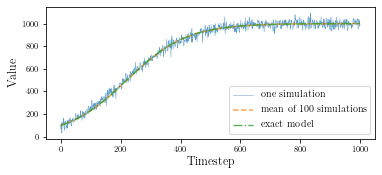

In [21]:
plt.plot(times, states, label='one simulation',linewidth=.5, alpha=.7)
plt.plot(times, list(map(lambda x: x[0], real_states)), '--',label='mean of 100 simulations', alpha=0.7, linewidth=1.5)
plt.plot(times, exact, '-.', label='exact model', alpha=0.8, linewidth=1.4)
plt.legend()
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.savefig("stochastic_run.pdf", bbox_inches='tight')

In [112]:
particles_to_test = np.linspace(10, 500, 25, dtype=int)#[10, 20, 30, 70, 100, 200, 300, 400, 500, 600, 800, 1000, 1100, 2000]#, 2200, 5000]
time = 1000
measurements = [model3.measure(t) for t in range(time)]


from multiprocessing import Pool
def test(N):
    pf = ParticleFilter(model3, N=N, resampling_algo='stratified_resample',
                        print_results=False, measurements=measurements,
                       prior_cov_matrix=[[50.]])
    _, pf_variances, pf_likelihood1 =  pf.run()
    
    pf = ParticleFilter(model3, N=N, resampling_algo='stratified_resample',
                        print_results=False, measurements=measurements,
                       prior_cov_matrix=[[50.]])
    _, pf_variances, pf_likelihood2 =  pf.run()
    
    
    mean = np.mean(pf_variances[int(.2 * time):])
    var = np.var(pf_variances[int(.2 * time):])

    return (pf_variances, mean, var, (pf_likelihood1 + pf_likelihood2)/2)

with Pool(10) as p:
    res = p.map(test, particles_to_test)

res = np.array(res)

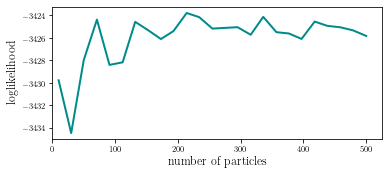

In [113]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(particles_to_test, res[:, 3], color='darkcyan')
ax.set_xlim(left=0)
ax.set_xlabel("number of particles")
ax.set_ylabel("loglikelihood")
# plt.xscale('log')
plt.savefig("stochastic_likelihood_vs_n.pdf", bbox_inches='tight')

In [6]:
Rs = [10. * x for x in range(1, 31)]
time = 100
measurements = [model3.measure(t) for t in range(time)]

from multiprocessing import Pool
def testR(R_):
    test_model = StochasticModelTauLeaping(x_0, events=[birth], step_size=1, 
                                   R=np.array([[R_]]))

    pf = ParticleFilter(test_model, N=300, resampling_algo='stratified_resample', measurements=measurements,
                       prior_cov_matrix=[[50.]])
    _, pf_variances, pf_likelihood =  pf.run()
    mean = np.mean(pf_variances[int(.2 * time):])
    var = np.var(pf_variances[int(.2 * time):])

    #return (pf_variances, mean, var, pf_likelihood)
    return pf_likelihood

with Pool(10) as p:
    res = p.map(testR, Rs)

res = np.array(res)

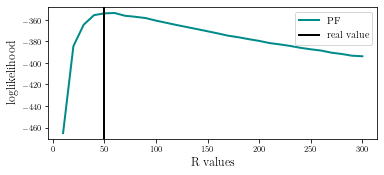

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(Rs, res, color='darkcyan', label='PF')
ax.axvline(x=50, color='k', label='real value')
ax.set_xlabel("R values")
ax.set_ylabel("loglikelihood")
plt.legend()
plt.savefig("stochastic_likelihood_vs_R.pdf", bbox_inches='tight')

# Parameter guessing

In [9]:
x_0 = np.array([100.])
b1 = 0.010
K1 = 1000

birth = Event(
    rate_calculator=lambda x: max(0, x[0] * b1 * (1 - float(x[0])/K1)),
    change_function=lambda x: [x[0] + 1]
    )

model_real = StochasticModelTauLeaping(x_0, events=[birth], step_size=1, 
                                   measurement_error_covariance=np.array([[50.]]))


possible_b1s = [0.001 * x for x in range(5, 15)]
possible_Ks = [100 * x for x in range(5, 15)]
possible_Rs = [10. * x for x in range(1, 10)]
tests = [(b, k, r) for b in possible_b1s for k in possible_Ks for r in possible_Rs]

time = 100
measurements = [model_real.measure(t) for t in range(time)]



def test_b(tup):
    b, k, r = tup
    test_event = Event(
            rate_calculator=lambda x: max(0, x[0] * b * (1 - float(x[0])/k)),
            change_function=lambda x: [x[0] + 1]
            )
    
    test_model = StochasticModelTauLeaping(x_0, events=[test_event], step_size=1, 
                                   measurement_error_covariance=np.array([[r]]))
    
    pf = ParticleFilter(test_model, N=100, resampling_algo='simple_resample', x_0=test_model.states[0], 
                        print_results=False, measurement_err_cov_matrix=[[r]],
                       prior_cov_matrix=[[50.]], measurements=measurements)
    
    _, _, pf_likelihood =  pf.run(time)
    
    return pf_likelihood

with Pool(10) as p:
    res = p.map(test_b, tests)

res = np.array(res)

Running PF with 100 particles: R................R...R........R......R.....R.....R........R....R...........R.....R......R.....R...R end
Running PF with 100 particles: R.........R.........R.......R..R.....R...R.......R........R...R.............R......R....R.....R..R. end
Running PF with 100 particles: RR.R.....R.......R.RR....RR..RR.RR...R.R...RR...R..R..R...R...R...R.R..R..RRR......R...RR....R.R.R. end
Running PF with 100 particles: R..............R.....R......R..R.....R.....R......R.......R...R.......R.....R....R.....R.R.....R..R end
Running PF with 100 particles: R........R.........R.R....R...R.R....R...R......R..R......R..R......R...R...R...R..R...R.R...R.R..R end
Running PF with 100 particles: R.............R.....R.......R...R......R........R....R.....R...R......R.....R...R....R..R..R...R..R end
Running PF with 100 particles: R.........R.........R.......R..R....R...R.......R..R.......R...R...........R.R....R....R.R.....R..R end
Running PF with 100 particles: RR.RR.....R......R.RR...

Running PF with 100 particles: R.........R..........R.......R...R....R...R.....R...R......R..R.....R.....R.R..R.....R...R...R..R.. end
Running PF with 100 particles: R.........R..........R........R.....R....R.......R.........R........R.......R......R.....R......R.. end
Running PF with 100 particles: R.........R.........R.........R....R.......R.......R.........R.............R..R.......R..R.....R... end
Running PF with 100 particles: RR.RR.R..R.........RR.....R...R...R....R........R..R......R..R.......R......R..R.......RR.....R..R. end
Running PF with 100 particles: RRRRR...RR.....R...RR.....R...R.R..R...R...RR...R..R..R...R..R....R..R.....RR..R...R...RR....R.R.R. end
Running PF with 100 particles: R................R...R......R.R...R....R...R.....R..R....R..R.R....R..R..R..R...R..R...R.R..R.R..R. end
Running PF with 100 particles: R..........R........R.......R..R...R...R........R....R.......R.........R....R.....R.....R.....R...R end
Running PF with 100 particles: R................R...R..

Running PF with 100 particles: RR..R.............R.R.......R.R...R....R........R..R......R...R........R.....R.....R....R....R...R. end
Running PF with 100 particles: R........R........R.R.....R...R...R...R.R..R....R..R......R...R.....R..R....R..R..R...R.R.R..R.R.R. end
Running PF with 100 particles: R........R..........R........R.R.........R........R.........R..R...........R.R.........R.R......R.. end
Running PF with 100 particles: R..............R....R.....R....R.....R.....R.......R.........R.........R.....R.........R.....R...R. end
Running PF with 100 particles: R...................R........R....R....R......R...R.......R....R.........R.....R......R.R......R..R end
Running PF with 100 particles: RR.R......R.......R.R.....R...R.....R..R........R..R.......R..R.......R.....R......R....R.R....R.R. end
Running PF with 100 particles: R............R.....R.R.......R..R....R.....R....R..R......R..R......R....R..R...R....R..R...R..R..R end
Running PF with 100 particles: R........R...........R..

Running PF with 100 particles: R.................R....R......R......R.....R.....R........R....R.......R.....R.........R....R..R... end
Running PF with 100 particles: RR.R.....R.......R.RR..R..R..RR.R....R.R...RR...R.RR...R..R..RR.....R.R....RR..R...R...RR.....R.RR. end
Running PF with 100 particles: RR.R......R........R.R....R...R...R....R........R..R......R..R.......R.....RR..R...R....R....R.R.R. end
Running PF with 100 particles: RR.RR....R.......R.RR.....R...R.R....R.R.....R..R.RR..R...R..R....R..R.....RR......R.R.RR....R.R.R. end
Running PF with 100 particles: R..........R........R.......R..R.....R...R.......R.........R.........R......R......R....R....R....R end
Running PF with 100 particles: R.........R..........R......R..R...R...R...R....R..R......R..R.......R.....R.R....R....R.R....R..R. end
Running PF with 100 particles: R..........R........R.......R...R......R........R..R.......R...........R.......R........R.....R..R. end
Running PF with 100 particles: R............R......R...

Running PF with 100 particles: R...............R...R.........R........R............R............R............R.........R........R. end
Running PF with 100 particles: R..R....RR.....R...RR....RRR..R......R...R..R...R..R..R...R...R..R...R....RRR.....R....RR....R.R.R. end
Running PF with 100 particles: RR..R...............R.........R......R.....R......R..........R.............R.R.........R.R.......R. end
Running PF with 100 particles: RR.R.....R.........R.R...RR...R........R........R.....R....R.......R.......RR........R..R........R. end
Running PF with 100 particles: R.......R...........R.........R......R...........R...........R..............R............R......... end
Running PF with 100 particles: R..........R..............R.......R.......................R..................R...................R. end
Running PF with 100 particles: R.......R..........R........R...R........R.........R..........R.............R..........R.....R....R end
Running PF with 100 particles: R........R..........R...

Running PF with 100 particles: RR.R...........R....R.....R...R........R........R.....R...R...R...R....R....R..........RR......R... end
Running PF with 100 particles: RR.RR....R.......R.RR.....R...R...R....R.....R..R..R..R...R...R..R..R.....R.R.....R....RR.R...R..R. end
Running PF with 100 particles: RR..R..............R.R........R........R.........R.........R.......R........R...........R.......R.. end
Running PF with 100 particles: R................R........R.....R...............R...............R.....................R...R........ end
Running PF with 100 particles: R.................R.......R.....R...............R..........R.............R.........R...........R... end
Running PF with 100 particles: RR.................R......R.....R......R........R.........R...R.............R..........R..R.......R end
Running PF with 100 particles: RR.RR....R.....R...RR.....R...R.RR.R...R.....R..R..R..R...R..R....R..R....RRR......R.R.RR....R.R.R. end
Running PF with 100 particles: R............R......R...

Running PF with 100 particles: R......R.............R..........R................R............R...................R.......R........ end
Running PF with 100 particles: R.............R...........R..........R.............R...........................R..............R.... end
Running PF with 100 particles: RR..R.R...R.R.....R.R....RR...R.RR...R...R..R...R..R..R...R..RR..R...R....RRR......R.R.RR.....R..R. end
Running PF with 100 particles: R........R..........R.........R..........R..............R.....R...........R........R..........R.... end
Running PF with 100 particles: RR.R......R........R.R.......RR......R...R......R..R......R...R...R....R....R..........RR.....R..R. end
Running PF with 100 particles: R......R.............R.........R.......R.........R...........R..............R..........R......R...R end
Running PF with 100 particles: RR..R.............R.R.....R...R......R.....R......R........R..R.............R..........R.R.......R. end
Running PF with 100 particles: R........R..........R...

Running PF with 100 particles: R.............R......R.........R................R.............R..............R..........R.......... end
Running PF with 100 particles: R...................R.........R........R...........R..........R...............R.........R......R... end
Running PF with 100 particles: RR.R........R.....R.R........RR........R....R....R.......RR...R...R........RR.........RR.R..R....R. end
Running PF with 100 particles: R................R.....R......R...R.............R............R..............R...........R......R... end
Running PF with 100 particles: R...........R.......R........RR........R.........R........R...R.............R.....R.....R....R...R. end
Running PF with 100 particles: R.........R...............R.....R..........R........R.........R..............R..........R.....R.... end
Running PF with 100 particles: RR..R.R..R.......R.RR....RR...R.RR.....R.....R..R.....R...R...R..R...R....RRR......R.R.RR....R...R. end
Running PF with 100 particles: R................R..R...

Running PF with 100 particles: R.........R....................R......................R...................R.............R.......... end
Running PF with 100 particles: R.......R...........R.........R..............R..........R.........R...............R............R... end
Running PF with 100 particles: R....R.............R......R.....R................R...........R...............R...........R.......R. end
Running PF with 100 particles: RR.R....RR.....R...RR....RR...R...R....R....R...R.....R...R...R..R.R...R..R.R........R.RR....R...R. end
Running PF with 100 particles: R.......R............R..........R..................R..............R...................R........R... end
Running PF with 100 particles: RR..R...R.R.R......R.R...RR....R.........R..R....R....R....R......R.......R.R........R..R......R... end
Running PF with 100 particles: RR..R.......R.......R.........R..........R.......R........R.......R.........R........R...R......... end
Running PF with 100 particles: R.........R.............

Running PF with 100 particles: RR..R.R..R..R......RR....RRR..R.....R.....R.R...R.....R...R...R.R.R......R..R....R...R.RR..R....RR. end
Running PF with 100 particles: RR.R......R........RR.....R...R........R........R.....R....R......R.......R.R..........R.R.......R. end
Running PF with 100 particles: R......R..................R............R...................R.................R................R.... end
Running PF with 100 particles: RR..R............R..R.........R............R.R.....R..R......R....R.........R.........R.R.........R end
Running PF with 100 particles: R...................R...........R..................R..............R...................R..........R. end
Running PF with 100 particles: R...............R...R..........R.............R..........R....R..............R............R......... end
Running PF with 100 particles: R.............R................R........................R.................R.....................R.. end
Running PF with 100 particles: R.......R...........R...

Running PF with 100 particles: R............R.................R...................R.......................R.............R......... end
Running PF with 100 particles: R.......R...........R.........R...............R.......R...........R............R........R.......... end
Running PF with 100 particles: R............R................R.....................R.....................R..............R......... end
Running PF with 100 particles: R.................R...........R.................R..........R................R...........R........R. end
Running PF with 100 particles: RR.RR.R...R.R......RR...RRRR..R....R...R....R...R.....R...R...R.RR.R...R.R..R....R....RRR...R..R... end
Running PF with 100 particles: R...........R.............R..................R................R........R..............R..........R. end
Running PF with 100 particles: RR.R........R.......R....RR.....R.........R.....R.....R....R......R.......R.R........R..R........R. end
Running PF with 100 particles: R............R..........

Running PF with 100 particles: RR.RR.R...R.R.....R.R....RR...R........R....R...R.....R...R...R.R.R......R..R.......R..RR...R..R... end
Running PF with 100 particles: RR..........R........R..........R..................R..........R..........R.....................R... end
Running PF with 100 particles: RR..R...R.........R.R......R..R........R.....R..R.....R...R.......R.........R...........R......R... end
Running PF with 100 particles: R......R.............R.................R....................R...................R.............R.... end
Running PF with 100 particles: RR..R...........R...R....RR.....R...........R.........R.......R..R........R.R........R...R......... end
Running PF with 100 particles: R...........R.......................R...................R.................R................R....... end
Running PF with 100 particles: R....R..............R...........R...............R..........R.............R...........R..R.......... end
Running PF with 100 particles: R...........R...........

Running PF with 100 particles: R....R........R........................R..............R............R..............R................ end
Running PF with 100 particles: R....R........R..............R............R..........RR...........R.......R.........R.......R...... end
Running PF with 100 particles: R........R....................R................R.................R.......R..........R.............. end
Running PF with 100 particles: R.............R..............R..............R...........R.........R.......R...........R..........R. end
Running PF with 100 particles: RR..R.R...R.R.......R.R..RRR..R..R....RR..R.R...R....RR...R...R.RRR.....R.R.R..R.R...R.R...R.....R. end
Running PF with 100 particles: R.......R................R................R........R..R..........R......R........R....R.........R.. end
Running PF with 100 particles: RR..........R........R...RR.........R........R........R.......R..R.......R........R......R.....R... end
Running PF with 100 particles: R............R..........

Running PF with 100 particles: R.......R............R..........R...............R.............R..........R.........R.............R. end
Running PF with 100 particles: RR.RR...RR..R......RR....RR...R.....R.....R.R...R.....R...R...R.R.R......RR.R...R...R..R.R.R.....R. end
Running PF with 100 particles: RR..R...RR......R...R....RR.....RR........R..R.....R..R....R.....RR......R..R....R...R..R...R...... end
Running PF with 100 particles: R.......R................R..................R...........R.........R..............R...............R. end
Running PF with 100 particles: R...................R......................R................R.............R..............R......... end
Running PF with 100 particles: R......R............R....RR..............R..R.........R..........R......R.R.........R....R..R...... end
Running PF with 100 particles: R.......R............R...R..........R.......R.........R..........R....R...R......R...R......R...... end
Running PF with 100 particles: R...........R...........

Running PF with 100 particles: R...........R..............R..............R...........R..........R......R........R....R..........R. end
Running PF with 100 particles: R...............R...............R..............R..................R.......R...........R............ end
Running PF with 100 particles: RR..R...R...........R.........R.............R.........R..........R.......R........R.....R.......... end
Running PF with 100 particles: R.....R.....................R................R...................R........R..............R......... end
Running PF with 100 particles: R..............R.....................R................R...........R.............R....R............. end
Running PF with 100 particles: RR........R....R..............R.............R.........R..........R....R...R.........R.......R...... end
Running PF with 100 particles: R.......R............R..........R............R..........R.........R..............R..........R...... end
Running PF with 100 particles: RR.R....RR..R......RR...

In [19]:
tests = np.array(tests)
d = list(zip(tests[:, 0], res))

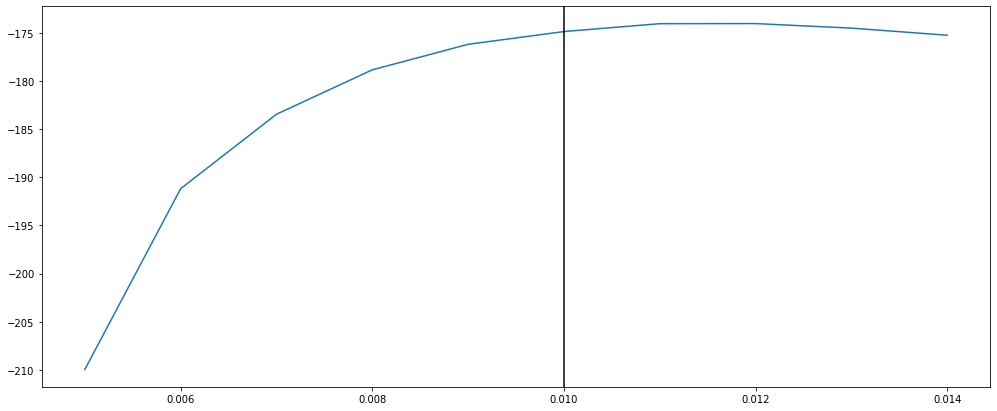

In [32]:
d2 = np.array([(x,np.average(list(filter(lambda tup:tup[0]==x, d)))) for x in possible_b1s])
plt.plot(d2[:, 0], d2[:, 1])
plt.axvline(x=b1, color='k')

Running PF with 100 particles: R..R........................R.....R....R..R..R..R..R..R..R.R.R.R.R.R.R.R.RRR.R.R.R.RR.R.R.RRR.RRRRR end
Running PF with 100 particles: R..R..........R..................R....R..R....R..R..R..R..R...R.....R..R.R.R...R.R..R..R..R..R.R.R. end
Running PF with 100 particles: R..R............R.................R........R......R...R.......R.......R....R.....R........R....R.R. end
Running PF with 100 particles: R..R..........R...................R............R....R.........R......R.....R.....R............R..R. end
Running PF with 100 particles: R..R..........R................R........R..........R.........R........R.......R........R.........R. end
Running PF with 100 particles: R..R..........R...................R......R......R...R....R....R......R....R...R..R.....R.......R..R end
Running PF with 100 particles: R..R........................R.....R....R.R..R..R..R..R..R..R..R...R.R.R.R.R.R.R.R.R.R.R.RRR.R.R.R.R end
Running PF with 100 particles: R..R............R.......

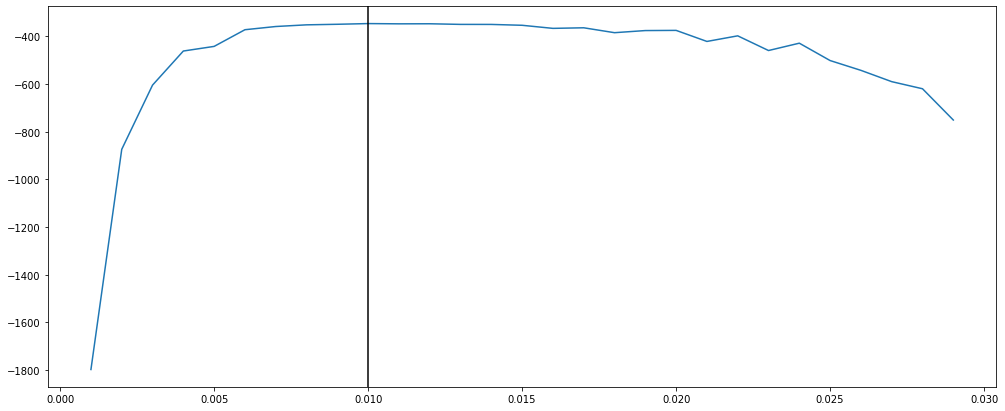

In [6]:
x_0 = np.array([100.])
b1 = 0.010
K1 = 1000
R = 50.

birth = Event(
    rate_calculator=lambda x: max(0, x[0] * b1 * (1 - float(x[0])/K1)),
    change_function=lambda x: [x[0] + 1]
    )

model_real = StochasticModelTauLeaping(x_0, events=[birth], step_size=1, 
                                   measurement_error_covariance=np.array([[R]]))


possible_b1s = [0.001 * x for x in range(1, 30)]
possible_Ks = [K1]
possible_Rs = [R]
tests = [(b, k, r) for b in possible_b1s for k in possible_Ks for r in possible_Rs]

time = 100
measurements = [model_real.measure(t) for t in range(time)]



def test_b(tup):
    b, k, r = tup
    test_event = Event(
            rate_calculator=lambda x: max(0, x[0] * b * (1 - float(x[0])/k)),
            change_function=lambda x: [x[0] + 1]
            )
    
    test_model = StochasticModelTauLeaping(x_0, events=[test_event], step_size=1, 
                                   measurement_error_covariance=np.array([[r]]))
    
    pf = ParticleFilter(test_model, N=100, resampling_algo='simple_resample', x_0=test_model.states[0], 
                        print_results=False, measurement_err_cov_matrix=[[r]],
                       prior_cov_matrix=[[50.]], measurements=measurements)
    
    _, _, pf_likelihood =  pf.run(time)
    
    return pf_likelihood

with Pool(10) as p:
    res = p.map(test_b, tests)

res = np.array(res)

plt.plot(possible_b1s, res)
plt.axvline(x=b1, color='k')

Running PF with 500 particles: R.......R.........R.R.......R...R....R...R.R...R...R...R.......R.R.R..R..R...R..R.R.R..R..R..R.R.R..RR.R.RR.R.RR.R.R..R..R.R..R.....R.R..R..R..R..R..R.R..R.R.R..R.R..R.R.R..R.R.R.R...R.R.R..R.R..R.R..R.R.R..R.R..RR..R.R..R.R..R.R.R..R.R.R..R.RR....R..R...R..R.R.R.R.R..R.R.R.R.RRR..R.R.R..R..R.R.R.R.R...R.R..R..R.R.R..R.R.R.R.R.R.R..R..R.R..RR..R.R.R..R.R.R.RR.R.R..R.R..R..R..R.R..R..R..R...R.R..R.R..R..R...R...R..R..R..R..R.R..R.R.R...R...R..R.R....R...R......R.R....R.....R.....R......R.......R....R......R.....R....................R.........R.....R.....R..........R....R.....R.............R.......R.............R....R..............R......R........R................R................R............................R.................................................R.................................R........................................................................................................................................R...............................

Running PF with 500 particles: R.....R.............R..........R...........R...........R.........R....R...........R.............R.R....R..R.R...R.............R....R.....R.............R.....R.....R....R......R...........R........R........R.......R....R.........R...........R..R.............R.....R.......R...R...R............R..R.R...............R........R........R......R....R......R......R...R.............R.............R.........R.................R.........R.......R.........R........................R..........................R..R...............R......R.........................R.....................R............................R..................R.............R.........R............................R..............................................................................................R.........................................................................................................................................................R...............................................

Running PF with 500 particles: R...R...R........R.......R........R....R.....R....R......R..R..R.........R.R..R.......R.R....R......R.........R....RR..R..R.R..R.R.R..R.R.R..R..R..R.R..R...R...R....R....R.R.R...R..R.R..R..R...RR...R...R...R.R.R...R..R.....RR.R....R.R.R..R......RR.R.R.R.R.R..R....R..R....R....R...R..R.RR.....R......R.R.R..R...R..R..R.R...R...R....R....R...R......R.......R........R...R.R......R....R..R....R.....R.......R....R....R.........R........R.....R.........R...R.....R.......R..........R.....R.........R.R.............R..........R....R...........R.....R.................R..........................R..................R.................................R..........................................................................................R..........................................................................................................................................................................................................................................

Running PF with 500 particles: R...R..R....R...R....RR...R..R...R.R..R.R...R...R.R..R..RR.R.R..R...R...R.R.R.R...R..R.RR.RR.RR...R.R..RR....R.R..R.R.RRR.RRR..RRRRR.R.R.RR.RRR.RR.R.R.R.R.RR.RRR.R.R.R.RR.RRR..RRR.RRRR.R.R.R.R.RR.RRRRR.RR.RRRR.R.R.RR.R.RR.RRRR.R..RR.RRRR.R.R.R..RR.R.R.RRR.R.RR.R.RR.RRR.R.RR..R.R.RR.R.R.R..R.R.R....R.R.R.R.R.RR.R.R.RR.R.R.R.R.R.R..R..RR..R.R...R..R...R..R..R....R.R.R.RR.R...R..R..R.R..R..R.R...R...R.R..R.R..R..R..R....R.R..R...R.....R...R........R..R...R..R..R....R....R...R....R...R..R.....R.R.......R...R........R...R.R...R.....R.......R....R............R....R....................R.......R.............R.......R..............................................R.............................................R....................................................................................................................................................................................................................................................................

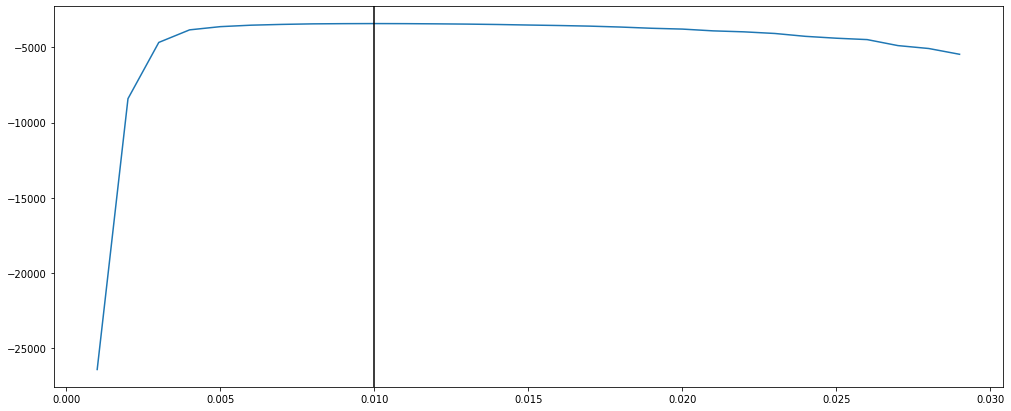

In [3]:
x_0 = np.array([100.])
b1 = 0.010
K1 = 1000
R = 50.

birth = Event(
    rate_calculator=lambda x: max(0, x[0] * b1 * (1 - float(x[0])/K1)),
    change_function=lambda x: [x[0] + 1]
    )

model_real = StochasticModelTauLeaping(x_0, events=[birth], step_size=1, 
                                   measurement_error_covariance=np.array([[R]]))


possible_b1s = [0.001 * x for x in range(1, 30)]
possible_Ks = [K1]
possible_Rs = [R]
tests = [(b, k, r) for b in possible_b1s for k in possible_Ks for r in possible_Rs]

time = 1000
measurements = [model_real.measure(t) for t in range(time)]



def test_b(tup):
    b, k, r = tup
    test_event = Event(
            rate_calculator=lambda x: max(0, x[0] * b * (1 - float(x[0])/k)),
            change_function=lambda x: [x[0] + 1]
            )
    
    test_model = StochasticModelTauLeaping(x_0, events=[test_event], step_size=1, 
                                   measurement_error_covariance=np.array([[r]]))
    
    pf = ParticleFilter(test_model, N=500, resampling_algo='simple_resample', x_0=test_model.states[0], 
                        print_results=False, measurement_err_cov_matrix=[[r]],
                       prior_cov_matrix=[[50.]], measurements=measurements)
    
    _, _, pf_likelihood =  pf.run(time)
    
    return pf_likelihood

with Pool(10) as p:
    res = p.map(test_b, tests)

res = np.array(res)

plt.plot(possible_b1s, res)
plt.axvline(x=b1, color='k')

/Users/ioan/SMC/PFClasses.py:183: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(Pyk)
/Users/ioan/SMC/PFClasses.py:183: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(Pyk)
/Users/ioan/SMC/PFClasses.py:183: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(Pyk)
/Users/ioan/SMC/PFClasses.py:183: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(Pyk)
/Users/ioan/SMC/PFClasses.py:183: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(Pyk)
/Users/ioan/SMC/PFClasses.py:183: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(Pyk)
/Users/ioan/SMC/PFClasses.py:183: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(Pyk)
/Users/ioan/SMC/PFClasses.py:183: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(Pyk)
/Users/ioan/SMC/PFClasses.py:183: RuntimeWarning: divide by zero encountered in log
  likelihood += np.l

Running PF with 300 particles: R................R...R......R.......R.....R...R.....R..R....R.R.R...R.R..R..R.R.R.R.R..R..R.R.R.R.R.R.RRRRRR.R.RR.R.R.R.RR.RRRR.R..RRRRRR.......................................................................................................................................................................................................................................................................................................................................................................... end
Running PF with 300 particles: RRRRRRRRRR........................................................................................................................................................................................................................................................................................................................................................................................................................................

/Users/ioan/SMC/PFClasses.py:183: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(Pyk)


Running PF with 300 particles: RRRRRRRRRR......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................... end
Running PF with 300 particles: RRRRRRR...........................................................................................................................................................................................................................................................................................................................................................................................................................................

Running PF with 300 particles: RRR................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................ end
Running PF with 300 particles: RRR...............................................................................................................................................................................................................................................................................................................................................................................................................................................

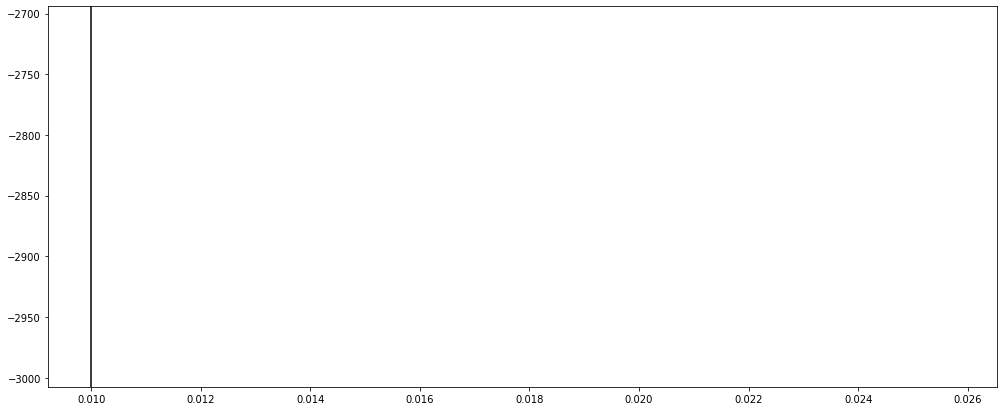

In [5]:
x_0 = np.array([100.])
b1 = 0.010
K1 = 1000
R = 50.

birth = Event(
    rate_calculator=lambda x: max(0, x[0] * b1 * (1 - float(x[0])/K1)),
    change_function=lambda x: [x[0] + 1]
    )

model_real = StochasticModelTauLeaping(x_0, events=[birth], step_size=1, 
                                   measurement_error_covariance=np.array([[R]]))


possible_b1s = np.linspace(0.0001, 1, 40)
possible_Ks = [K1]
possible_Rs = [R]
tests = [(b, k, r) for b in possible_b1s for k in possible_Ks for r in possible_Rs]

time = 500
measurements = [model_real.measure(t) for t in range(time)]



def test_b(tup):
    b, k, r = tup
    test_event = Event(
            rate_calculator=lambda x: max(0, x[0] * b * (1 - float(x[0])/k)),
            change_function=lambda x: [x[0] + 1]
            )
    
    test_model = StochasticModelTauLeaping(x_0, events=[test_event], step_size=1, 
                                   measurement_error_covariance=np.array([[r]]))
    
    pf = ParticleFilter(test_model, N=300, resampling_algo='simple_resample', x_0=test_model.states[0], 
                        print_results=False, measurement_err_cov_matrix=[[r]],
                       prior_cov_matrix=[[50.]], measurements=measurements)
    
    _, _, pf_likelihood =  pf.run(time)
    
    return pf_likelihood

with Pool(10) as p:
    res = p.map(test_b, tests)

res = np.array(res)

plt.plot(possible_b1s, res)
plt.axvline(x=b1, color='k')

In [7]:
list(zip(possible_b1s, res))

[(0.0001, -inf),
 (0.025738461538461536, -2850.7985920164365),
 (0.05137692307692308, -inf),
 (0.07701538461538461, -inf),
 (0.10265384615384615, -inf),
 (0.12829230769230768, -inf),
 (0.1539307692307692, -inf),
 (0.17956923076923076, -inf),
 (0.20520769230769229, -inf),
 (0.2308461538461538, -inf),
 (0.25648461538461537, -inf),
 (0.2821230769230769, -inf),
 (0.3077615384615384, -inf),
 (0.3334, -inf),
 (0.35903846153846153, -inf),
 (0.384676923076923, -inf),
 (0.4103153846153846, -inf),
 (0.43595384615384614, -inf),
 (0.46159230769230764, -inf),
 (0.4872307692307692, -inf),
 (0.5128692307692307, -inf),
 (0.5385076923076922, -inf),
 (0.5641461538461539, -inf),
 (0.5897846153846154, -inf),
 (0.6154230769230769, -inf),
 (0.6410615384615385, -inf),
 (0.6667, -inf),
 (0.6923384615384615, -inf),
 (0.7179769230769231, -inf),
 (0.7436153846153846, -inf),
 (0.7692538461538461, -inf),
 (0.7948923076923077, -inf),
 (0.8205307692307692, -inf),
 (0.8461692307692307, -inf),
 (0.8718076923076923, -i

/Users/ioan/SMC/PFClasses.py:183: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(Pyk)


Running PF with 300 particles: RR.R.............R...R...R......R....R.R..R..R...R..R.R.R.R..R..R.R.R..R.R.R.R.R.RRR.R.RR.R.R.RR.R.R.R.R.R.RRRRR.R.RR.RRRRRRRR.RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR.RRRRRRRRRRRRRRRRRRRRR.R.RRRRRR.RRRRRR.RR.RR.RR.RRRRRRRR.RRR.R.R.R.RRRRRRRRR.R.RRR.R.R.RRRRR.RRRR.RRRRRRR.R.RRRR.R.RRR.R.R.R.RR.R.R.R.R.R.R.R.R..R.R.R.R.R.R.R.R..R...R..R..R. end
Running PF with 300 particles: RR.R................R.....R.....R...R.R.R..R..R...R..R..R.R..R...R.R.R..R.R.R..R.R.R.R.R.R.R..R.R.R.R.R.R..R.R..RRR.RRR.R.R.RRR..R................................................................................................................................................................................................................................................................................................................

Running PF with 300 particles: R.....R...R.........R....R..R.....R.......R..R.R.......R...R..R.R...R.R...R....R.....R.R...R.R..R.R.R.R..R...R.RR.R..R...R.R..R......R.R....R....R..R.R...R...R...R..R..R..R.R.R..R.R..R...R..R.R...R.R.R....R.R....R...R..R.R....R..R.R.R..R.R.R.RR...R..R.R.R..R...R..R...R.R.RR..R..R..R.R.....RR.R..R..R..R......R..R.R..R.R..R.R.R.R.R..R...RR.R..R.R.R....R...R.R.....R.RR.........R.........R....R...R..........R..........R...........R.......R..........R........R..........R.........R......R............ end
Running PF with 300 particles: R.....R...R.....R.....R....R..R...R.....R..R..R......R...R.R..R.R...R.R..R...R..R.....R...R..R..R.R.R.R.R.R.R..RR.R.RR..R.R.R.R..R..R.R..R....R...R.R.R..R.R..R.R..R..R.R.RRR.R.R.R.R..R.R.R.RRRR.R.R.R.R...R.RR...R..R.R..R.R...R.R..RR.R.RR.R.R.RR..R..RR.R.R..R..RR.R..R.R.RR.R..R..R.R.R.R....R.RR.R.R.R.R..R....R.R.RR.R.R.R.R.RR.R.R.R.R.R..R.R..R.R.R.R..R..R.R....R.R.R..R......RR.......R...R..R..R.......R.....R........R...R...........

/Users/ioan/SMC/PFClasses.py:183: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(Pyk)
/Users/ioan/SMC/PFClasses.py:183: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(Pyk)
/Users/ioan/SMC/PFClasses.py:183: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(Pyk)
/Users/ioan/SMC/PFClasses.py:183: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(Pyk)


Running PF with 300 particles: RR.R..R..R..RR.R..RR.RR.R.RRR.R.R.RR.R.R.RRR.RRRR.R.RRRRRRRR.RRRRRRRRRRRRRRRRRRRRRR.RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR.RRRRRRRRRRRRR.RR.RRRRR.RR.RR.RR.R.RR..RRRR.RR.R.R.R.R.R.R.R.R..R.R.R.RR.R.R...R.R.R.R.R..R...R..R..R.R....R...R..R...R...R....R..R...R...R....R..R..R...R......R.. end
Running PF with 300 particles: RR.R..R..R..RR.R..RR.RR.R.RRRR.R.RRR.R.R.RRR.RRRR.R.RRRRRRRR.RRRRRRRRRR.RRRRRRRRRRR.RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR.RRRRRRRR.RR.RR.RR.R.RR..RRR.R.R.R.R.R.R.R.R.R.R.R.R.R..R.R.RR...R.R.R.R.R....R..R..

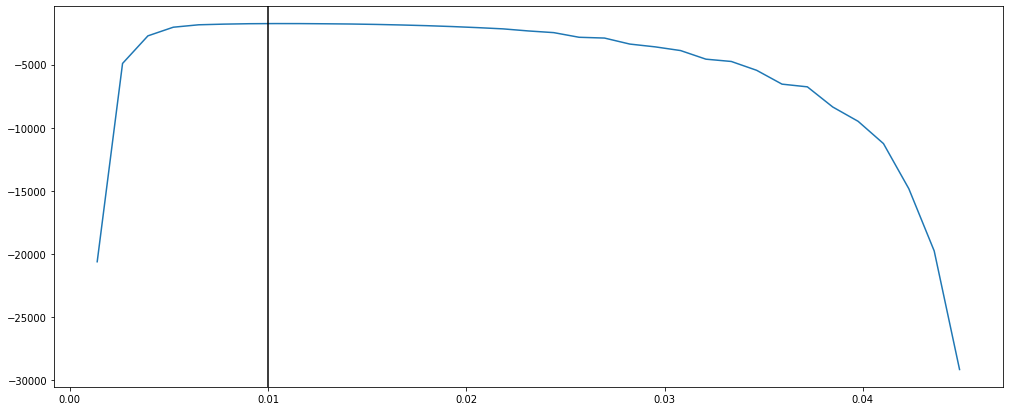

In [8]:
x_0 = np.array([100.])
b1 = 0.010
K1 = 1000
R = 50.

birth = Event(
    rate_calculator=lambda x: max(0, x[0] * b1 * (1 - float(x[0])/K1)),
    change_function=lambda x: [x[0] + 1]
    )

model_real = StochasticModelTauLeaping(x_0, events=[birth], step_size=1, 
                                   measurement_error_covariance=np.array([[R]]))


possible_b1s = np.linspace(0.0001, 0.05, 40)
possible_Ks = [K1]
possible_Rs = [R]
tests = [(b, k, r) for b in possible_b1s for k in possible_Ks for r in possible_Rs]

time = 500
measurements = [model_real.measure(t) for t in range(time)]



def test_b(tup):
    b, k, r = tup
    test_event = Event(
            rate_calculator=lambda x: max(0, x[0] * b * (1 - float(x[0])/k)),
            change_function=lambda x: [x[0] + 1]
            )
    
    test_model = StochasticModelTauLeaping(x_0, events=[test_event], step_size=1, 
                                   measurement_error_covariance=np.array([[r]]))
    
    pf = ParticleFilter(test_model, N=300, resampling_algo='simple_resample', x_0=test_model.states[0], 
                        print_results=False, measurement_err_cov_matrix=[[r]],
                       prior_cov_matrix=[[50.]], measurements=measurements)
    
    _, _, pf_likelihood =  pf.run(time)
    
    return pf_likelihood

with Pool(10) as p:
    res = p.map(test_b, tests)

res = np.array(res)

plt.plot(possible_b1s, res)
plt.axvline(x=b1, color='k')

In [ ]:
x_0 = np.array([100.])
b1 = 0.010
K1 = 1000
R = 50.

birth = Event(
    rate_calculator=lambda x: max(0, x[0] * b1 * (1 - float(x[0])/K1)),
    change_function=lambda x: [x[0] + 1]
    )

model_real = StochasticModelTauLeaping(x_0, events=[birth], step_size=1, 
                                   measurement_error_covariance=np.array([[R]]))


possible_b1s = [b1]#np.linspace(0.0001, 0.05, 40)
possible_Ks = np.linspace(10, 30000, 40)
possible_Rs = [R]
tests = [(b, k, r) for b in possible_b1s for k in possible_Ks for r in possible_Rs]

time = 500
measurements = [model_real.measure(t) for t in range(time)]


def test_b(tup):
    b, k, r = tup
    test_event = Event(
            rate_calculator=lambda x: max(0, x[0] * b * (1 - float(x[0])/k)),
            change_function=lambda x: [x[0] + 1]
            )
    
    test_model = StochasticModelTauLeaping(x_0, events=[test_event], step_size=1, 
                                   measurement_error_covariance=np.array([[r]]))
    
    pf = ParticleFilter(test_model, N=300, resampling_algo='simple_resample', x_0=test_model.states[0], 
                        print_results=False, measurement_err_cov_matrix=[[r]],
                       prior_cov_matrix=[[50.]], measurements=measurements)
    
    _, _, pf_likelihood =  pf.run(time)
    
    return pf_likelihood

with Pool(10) as p:
    res = p.map(test_b, tests)

res = np.array(res)

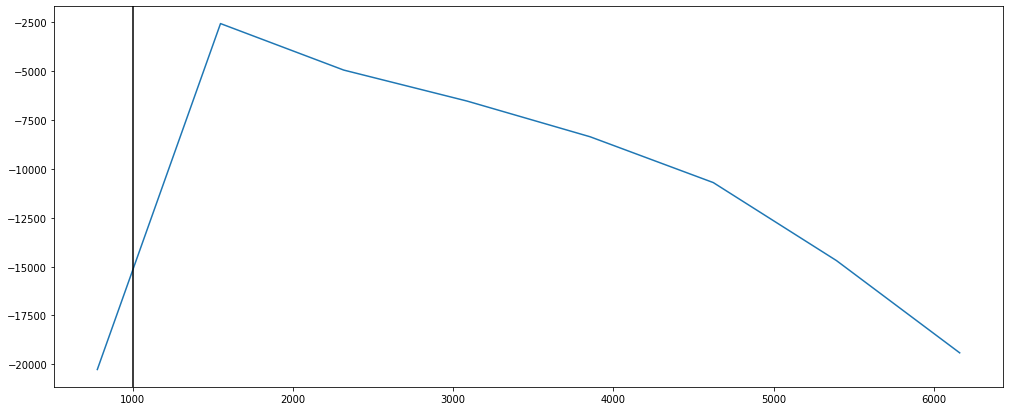

In [34]:
plt.plot(possible_Ks, res)
plt.axvline(x=K1, color='k')

In [36]:
list(zip(possible_Ks, res))

[(10.0, -inf),
 (778.974358974359, -20267.742185126448),
 (1547.948717948718, -2559.5094837270344),
 (2316.923076923077, -4939.48031544573),
 (3085.897435897436, -6524.093171403698),
 (3854.871794871795, -8353.56347540224),
 (4623.846153846154, -10699.320462971624),
 (5392.820512820513, -14693.246132020067),
 (6161.794871794872, -19414.926568405946),
 (6930.769230769231, -inf),
 (7699.74358974359, -inf),
 (8468.71794871795, -inf),
 (9237.692307692309, -inf),
 (10006.666666666668, -inf),
 (10775.641025641025, -inf),
 (11544.615384615385, -inf),
 (12313.589743589744, -inf),
 (13082.564102564103, -inf),
 (13851.538461538463, -inf),
 (14620.51282051282, -inf),
 (15389.48717948718, -inf),
 (16158.461538461539, -inf),
 (16927.4358974359, -inf),
 (17696.410256410258, -inf),
 (18465.384615384617, -inf),
 (19234.358974358976, -inf),
 (20003.333333333336, -inf),
 (20772.30769230769, -inf),
 (21541.28205128205, -inf),
 (22310.25641025641, -inf),
 (23079.23076923077, -inf),
 (23848.20512820513, -i

/Users/ioan/SMC/PFClasses.py:194: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(Pyk)
/Users/ioan/SMC/PFClasses.py:194: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(Pyk)
/Users/ioan/SMC/PFClasses.py:194: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(Pyk)
/Users/ioan/SMC/PFClasses.py:194: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(Pyk)
/Users/ioan/SMC/PFClasses.py:194: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(Pyk)
/Users/ioan/SMC/PFClasses.py:194: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(Pyk)
/Users/ioan/SMC/PFClasses.py:194: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(Pyk)
/Users/ioan/SMC/PFClasses.py:194: RuntimeWarning: divide by zero encountered in log
  likelihood += np.log(Pyk)
/Users/ioan/SMC/PFClasses.py:194: RuntimeWarning: divide by zero encountered in log
  likelihood += np.l

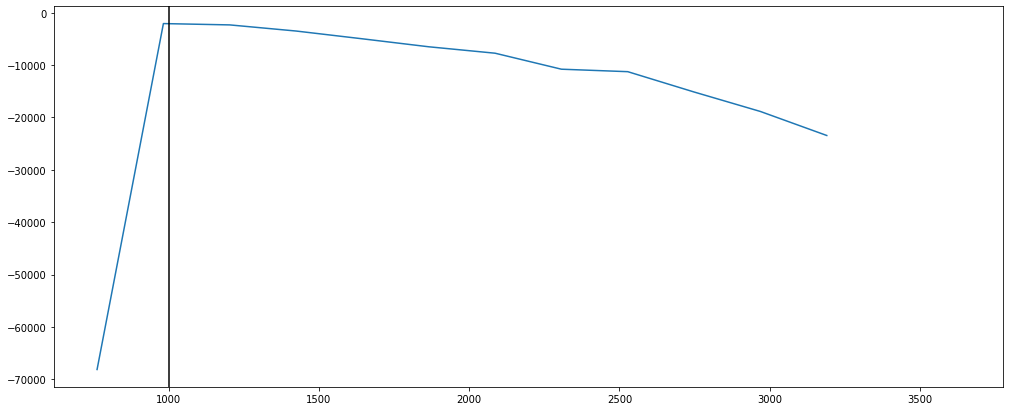

In [16]:
x_0 = np.array([100.])
b1 = 0.010
K1 = 1000
R = 50.

birth = Event(
    rate_calculator=lambda x: max(0, x[0] * b1 * (1 - float(x[0])/K1)),
    change_function=lambda x: [x[0] + 1]
    )

model_real = StochasticModelTauLeaping(x_0, events=[birth], step_size=1, 
                                   measurement_error_covariance=np.array([[R]]))


possible_b1s = [b1] #np.linspace(0.0001, 0.05, 40)
possible_Ks = np.linspace(100, 6500, 30)
possible_Rs = [R]
tests = [(b, k, r) for b in possible_b1s for k in possible_Ks for r in possible_Rs]

time = 600
measurements = [model_real.measure(t) for t in range(time)]


def test_b(tup):
    b, k, r = tup
    test_event = Event(
            rate_calculator=lambda x: max(0, x[0] * b * (1 - float(x[0])/k)),
            change_function=lambda x: [x[0] + 1]
            )
    
    test_model = StochasticModelTauLeaping(x_0, events=[test_event], step_size=1, 
                                   measurement_error_covariance=np.array([[r]]))
    
    pf = ParticleFilter(test_model, N=300, resampling_algo='simple_resample', x_0=test_model.states[0], 
                        print_results=False, measurement_err_cov_matrix=[[r]],
                       prior_cov_matrix=[[50.]], measurements=measurements)
    
    _, _, pf_likelihood =  pf.run(time)
    
    return pf_likelihood

with Pool(10) as p:
    res = p.map(test_b, tests)

res = np.array(res)

plt.plot(possible_Ks, res)
plt.axvline(x=K1, color='k')